# Read the dataset

In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt #描画ライブラリ
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# import pathlib
# import glob
# import math

# Show all the rows and columns up to 200
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [2]:
# Data set for seller/buyer
df_prediction_afterDA = pd.read_csv('df_prediction.csv', sep=',', header=0)
df_prediction_afterDA = df_prediction_afterDA[["DateTime", "Spot", "High", "Low", "Close", "Close_pred"]]
df_prediction_afterDA.head()

,DateTime,Spot,High,Low,Close,Close_pred
0,2017-08-10 00:00:00,7.98,12.98,5.94,9.4,7.89
1,2017-08-10 00:30:00,7.67,12.67,5.63,9.4,7.72
2,2017-08-10 01:00:00,6.86,11.86,5.58,9.4,7.26
3,2017-08-10 01:30:00,6.58,11.58,4.91,9.4,6.79
4,2017-08-10 02:00:00,6.62,11.62,4.88,9.4,6.82


In [3]:
# Data set for trader
df_prediction_beforeDA = pd.read_csv('df_prediction_trader.csv', sep=',', header=0)
df_prediction_beforeDA.head()

,Date,HH,Open,High,Low,Close,Spot,Spot_1daylag,DateTime,Close_pred
0,2017-08-10,1,10.70,12.98,5.94,9.4,8.19,8.10,2017-08-10 00:00:00,7.83
1,2017-08-10,2,6.89,12.67,5.63,9.4,8.04,8.00,2017-08-10 00:30:00,7.58
2,2017-08-10,3,6.42,11.86,5.58,9.4,7.93,8.05,2017-08-10 01:00:00,7.55
3,2017-08-10,4,10.30,11.58,4.91,9.4,7.73,7.80,2017-08-10 01:30:00,7.27
4,2017-08-10,5,10.50,11.62,4.88,9.4,7.93,7.94,2017-08-10 02:00:00,7.35


# Benchmark

## Benchmark 1 (Trade only on DA market)
- No strategy: Players trade on DA market as much as possible to avoid imbalance risks (100% position only on DA market)<p>
- Calculate return and risk with "Spot price"

### Requierd dataset

In [4]:
# Need actual spot, high, close price
df_benchmark1 = df_prediction_afterDA.copy()

# Drop Close_pred and others for intraday market since players who trade without strategy need only spot price.
df_benchmark1 = df_benchmark1.drop(["Close_pred", "High", "Low", "Close"], axis=1)

df_benchmark1.head()

,DateTime,Spot
0,2017-08-10 00:00:00,7.98
1,2017-08-10 00:30:00,7.67
2,2017-08-10 01:00:00,6.86
3,2017-08-10 01:30:00,6.58
4,2017-08-10 02:00:00,6.62


### Evaluation

Expected return: 8.53
Standard deviation: 4.51
Sharp ratio: 1.89


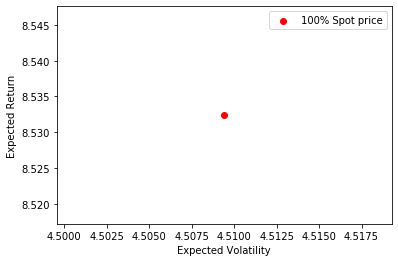

In [5]:
# fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
plt.scatter(x=df_benchmark1["Spot"].std(), y=df_benchmark1["Spot"].mean(), color="r", label="100% Spot price")
print("Expected return: {}".format(df_benchmark1["Spot"].mean().round(2)))
print("Standard deviation: {}".format(df_benchmark1["Spot"].std().round(2)))
print("Sharp ratio: {}".format(round(df_benchmark1["Spot"].mean()/df_benchmark1["Spot"].std(), 2)))

plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.legend();

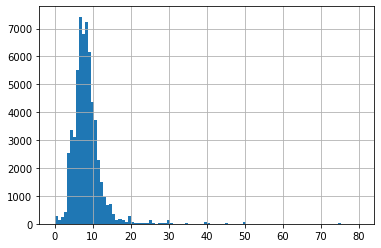

In [6]:
df_benchmark1["Spot"].hist(bins=100);

## Benchmark2 (Trade only on Intraday market)
- No strategy: Players trade on Intra market (100% position only on Intra market)<p>
    --> ※ This strategy would be not realistic due to imbalence risk, but just try to look at the performance <p>
- Calculate return and risk with "Close price"

### Required dataset

In [7]:
# Need actual spot, high, close price
df_benchmark2 = df_prediction_afterDA.copy()

# Drop Close_pred and others for intraday market since players who trade without strategy need only spot price.
df_benchmark2 = df_benchmark2.drop(["Close_pred", "High", "Low", "Spot"], axis=1)

df_benchmark2.head()

,DateTime,Close
0,2017-08-10 00:00:00,9.4
1,2017-08-10 00:30:00,9.4
2,2017-08-10 01:00:00,9.4
3,2017-08-10 01:30:00,9.4
4,2017-08-10 02:00:00,9.4


### Evaluation

Expected return: 8.58
Standard deviation: 5.12
Sharp ratio: 1.68


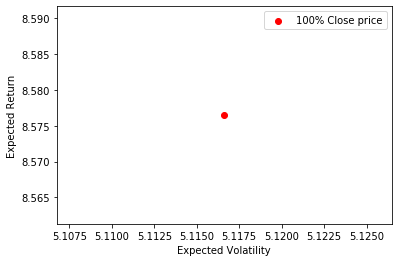

In [8]:
# fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
plt.scatter(x=df_benchmark2["Close"].std(), y=df_benchmark2["Close"].mean(), color="r", label="100% Close price")
print("Expected return: {}".format(df_benchmark2["Close"].mean().round(2)))
print("Standard deviation: {}".format(df_benchmark2["Close"].std().round(2)))
print("Sharp ratio: {}".format(round(df_benchmark2["Close"].mean()/df_benchmark2["Close"].std(), 2)))

plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.legend();

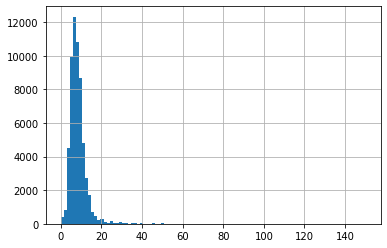

In [9]:
df_benchmark2["Close"].hist(bins=100);

As a result, both expected return and standard deviation on Intraday market are higher than that on DA market <p>
--> Sharp ratio on Intraday market in lower than that of DA market <p>
--> Return is high, but TOO RISKY

※ The benchmark1 will be compared with the following strategies. 
- Strategies for seller aim to sell their posision for higher price than the benchmark
- Strategies for buyer aim to buy their posision for lower price than the benchmark

# Trading strategies for sellers (e.g. power producers)

[Assumption]<p>
1)	All of the market participants are price-takers and their trading decisions do not affect the price on any market. <p>
2)	Auction strategy at the DA market is ignored. Realised spot price is used for evaluating the portfolios since spot price is determined based on a single price auction system.<p>
3)	Strategic decisions are made based only on the price before each prediction point, and trading performance is evaluated based on realised price after the market.<p>
4)	Trading volume is ignored. Therefore, transaction fees are also ignored. Return and risk will be defined in the next section.<p>
5)	The iceberg order  is ignored since the information of the ask/bid order book is not available. <p>
6)	All the orders can be executed as far as the price of the order is within the range of the high and low price of that day. It also means there are no penalties due to imbalance.<p>
7)	For electricity producers, the influence of curtailment on their operating and trading decision making is ignored. Curtailment is restriction of generating electricity especially for renewable energy power plants.<p>
8)	For retailers, the influence of supply contracts with customers on trading decision making is ignored.<p>

## Strategy 1 (Trading with prediction before DA) without execution strategy
- Choose the higher price of　1day-lagged spot price or the predicted close price(before DA)<p>
    --> Determinint trading position depends on the prices

In [10]:
Benchmark_seller = df_benchmark1["Spot"].round(2)
Benchmark_seller

0         7.98
1         7.67
2         6.86
3         6.58
4         6.62
         ...  
59515    35.00
59516    45.00
59517    40.00
59518    35.00
59519    25.00
Name: Spot, Length: 59520, dtype: float64

### Required dataset

In [11]:
# Need predicted price before DA market and 1 dayahead spot price
df_seller_strategy1 = df_prediction_beforeDA.copy()
df_seller_strategy1["Spot_1dayahead"] = df_seller_strategy1["Spot"].shift(48)
# Drop rows that include NaN
df_seller_strategy1 = df_seller_strategy1.dropna(how='any', axis=0).reset_index(drop=True)

# Make lists for price information
SpotLag_list = list(df_seller_strategy1["Spot_1dayahead"])
Spot_list = list(df_seller_strategy1["Spot"])
High_list = list(df_seller_strategy1["High"])
Close_list = list(df_seller_strategy1["Close"])
Pred_list = list(df_seller_strategy1["Close_pred"])
# Judge_success = []

# list for executed orders
Executed = []
Judge = []
Position = []
for sl, s, h, c, p  in zip(SpotLag_list, Spot_list, High_list, Close_list, Pred_list):
    # Trade on DA market
    if sl >= p:
        Executed.append(s)
        Judge.append("True")
        Position.append("DA")
    # Trade on Intra markets
    else:
        if p <= h:
            Executed.append(p)
            Judge.append("True")
            Position.append("Intra")
        else:
            Executed.append(c)
            Judge.append("False")        
            Position.append("Intra")
df_seller_strategy1["ExecutedOrder"] = pd.Series(Executed)
df_seller_strategy1["Judge"] = pd.Series(Judge)
df_seller_strategy1["Position"] = pd.Series(Position)

#     Judge_success.append((df_seller_bench["Judge_" + str(i) + "%"] == 'True').sum())
# #For graph
# Judge_success = pd.Series(Judge_success)

In [12]:
df_seller_strategy1.tail()

,Date,HH,Open,High,Low,Close,Spot,Spot_1daylag,DateTime,Close_pred,Spot_1dayahead,ExecutedOrder,Judge,Position
59467,2020-12-31,44,35.0,70.0,33.00,70.00,35.0,50.00,2020-12-31 21:30:00,18.81,50.00,35.0,True,DA
59468,2020-12-31,45,42.0,70.0,41.01,45.48,40.0,40.00,2020-12-31 22:00:00,19.55,40.00,40.0,True,DA
59469,2020-12-31,46,42.0,70.0,35.00,41.33,40.0,40.00,2020-12-31 22:30:00,17.98,40.00,40.0,True,DA
59470,2020-12-31,47,37.0,70.0,33.93,36.66,35.0,33.21,2020-12-31 23:00:00,14.78,33.21,35.0,True,DA
59471,2020-12-31,48,27.0,37.5,23.93,26.46,25.0,25.00,2020-12-31 23:30:00,12.57,25.00,25.0,True,DA


### Evaluation

In [13]:
# The percentage of DA position 
DA_position = df_seller_strategy1["Position"].value_counts()[0] 
Intra_position = df_seller_strategy1["Position"].value_counts()[1]
DA_ratio = round(DA_position / (DA_position+Intra_position)*100, 2)
DA_ratio

64.11

Position: DA 64.11%
Expected return: 9.18
Standard deviation: 4.71
Sharp ratio: 1.95
Information ratio: 0.2


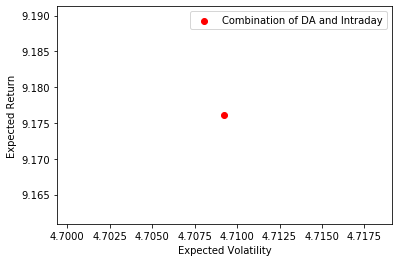

In [14]:
# fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
plt.scatter(x=df_seller_strategy1["ExecutedOrder"].std(), y=df_seller_strategy1["ExecutedOrder"].mean(), color="r", label="Combination of DA and Intraday")
print("Position: DA {}".format(round(DA_position / (DA_position+Intra_position)*100, 2)) + "%")
print("Expected return: {}".format(df_seller_strategy1["ExecutedOrder"].mean().round(2)))
print("Standard deviation: {}".format(df_seller_strategy1["ExecutedOrder"].std().round(2)))
print("Sharp ratio: {}".format(round(df_seller_strategy1["ExecutedOrder"].mean()/df_seller_strategy1["ExecutedOrder"].std(), 2)))
print("Information ratio: {}".format(round((df_seller_strategy1["ExecutedOrder"] - Benchmark_seller).mean()/(df_seller_strategy1["ExecutedOrder"] - Benchmark_seller).std(), 2)))

plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.legend();

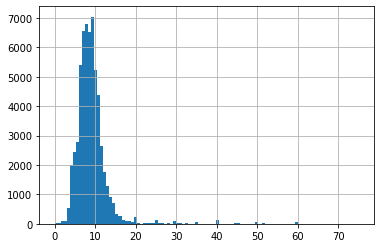

In [15]:
df_seller_strategy1["ExecutedOrder"].hist(bins=100);

Much higher than benchmarks

## Strategy 1 with execusion strategy
- Derive strategy1 with execution strategy <p>
※ 10-fold evaluation is necessary

### Required dataset

In [16]:
# Need predicted price before DA market and 1 dayahead spot price
df_seller_strategy1_ex = df_prediction_beforeDA.copy()
df_seller_strategy1_ex["Spot_1dayahead"] = df_seller_strategy1_ex["Spot"].shift(48)
# Drop rows that include NaN
df_seller_strategy1_ex = df_seller_strategy1_ex.dropna(how='any', axis=0).reset_index(drop=True)

# Make lists for price information
SpotLag_list = list(df_seller_strategy1_ex["Spot_1dayahead"])
Spot_list = list(df_seller_strategy1["Spot"])
High_list = list(df_seller_strategy1_ex["High"])
Close_list = list(df_seller_strategy1_ex["Close"])
# Judge_success = []

# Order and execution with execusion range
for i in list(range(0, 51, 1)):
    # list for executed orders
    Executed_i = []
    # list for checking the execution results
    Judge_i = []    
    Position_i = []    
    # Derive the predicted price with the range from +0% ~ +20%
    Pred_list_i = list((df_seller_strategy1_ex["Close_pred"]* (1 + i/100)).round(2))
    for sl, s, h, c, p in zip(SpotLag_list, Spot_list, High_list, Close_list, Pred_list_i):
        # Trade on DA market
        if sl >= p:
            Executed_i.append(s)
            Judge.append("True")
            Position_i.append("DA")
        # Trade on Intra markets
        else:
            if p <= h:
                Executed_i.append(p)
                Judge_i.append("True")
                Position_i.append("Intra")
            else:
                Executed_i.append(c)
                Judge_i.append("False")
                Position_i.append("Intra")
    df_seller_strategy1_ex["Exec_" + str(i) + "%"] = pd.Series(Executed_i)
    df_seller_strategy1_ex["Judge_" + str(i) + "%"] = pd.Series(Judge_i)
    df_seller_strategy1_ex["Position_" + str(i) + "%"] = pd.Series(Position_i)

#     Judge_success.append((df_seller_bench["Judge_" + str(i) + "%"] == 'True').sum())
# #For graph
# Judge_success = pd.Series(Judge_success)

In [17]:
df_seller_strategy1_ex.head()

,Date,HH,Open,High,Low,Close,Spot,Spot_1daylag,DateTime,Close_pred,Spot_1dayahead,Exec_0%,Judge_0%,Position_0%,Exec_1%,Judge_1%,Position_1%,Exec_2%,Judge_2%,Position_2%,Exec_3%,Judge_3%,Position_3%,Exec_4%,Judge_4%,Position_4%,Exec_5%,Judge_5%,Position_5%,Exec_6%,Judge_6%,Position_6%,Exec_7%,Judge_7%,Position_7%,Exec_8%,Judge_8%,Position_8%,Exec_9%,Judge_9%,Position_9%,Exec_10%,Judge_10%,Position_10%,Exec_11%,Judge_11%,Position_11%,Exec_12%,Judge_12%,Position_12%,Exec_13%,Judge_13%,Position_13%,Exec_14%,Judge_14%,Position_14%,Exec_15%,Judge_15%,Position_15%,Exec_16%,Judge_16%,Position_16%,Exec_17%,Judge_17%,Position_17%,Exec_18%,Judge_18%,Position_18%,Exec_19%,Judge_19%,Position_19%,Exec_20%,Judge_20%,Position_20%,Exec_21%,Judge_21%,Position_21%,Exec_22%,Judge_22%,Position_22%,Exec_23%,Judge_23%,Position_23%,Exec_24%,Judge_24%,Position_24%,Exec_25%,Judge_25%,Position_25%,Exec_26%,Judge_26%,Position_26%,Exec_27%,Judge_27%,Position_27%,Exec_28%,Judge_28%,Position_28%,Exec_29%,Judge_29%,Position_29%,Exec_30%,Judge_30%,Position_30%,Exec_31%,Judge_31%,Position_31%,Exec_32%,Judge_32%,Position_32%,Exec_33%,Judge_33%,Position_33%,Exec_34%,Judge_34%,Position_34%,Exec_35%,Judge_35%,Position_35%,Exec_36%,Judge_36%,Position_36%,Exec_37%,Judge_37%,Position_37%,Exec_38%,Judge_38%,Position_38%,Exec_39%,Judge_39%,Position_39%,Exec_40%,Judge_40%,Position_40%,Exec_41%,Judge_41%,Position_41%,Exec_42%,Judge_42%,Position_42%,Exec_43%,Judge_43%,Position_43%,Exec_44%,Judge_44%,Position_44%,Exec_45%,Judge_45%,Position_45%,Exec_46%,Judge_46%,Position_46%,Exec_47%,Judge_47%,Position_47%,Exec_48%,Judge_48%,Position_48%,Exec_49%,Judge_49%,Position_49%,Exec_50%,Judge_50%,Position_50%
0,2017-08-11,1,6.86,11.50,5.39,7.41,7.74,8.19,2017-08-11 00:00:00,7.55,8.19,7.74,True,DA,7.74,True,DA,7.74,True,DA,7.74,True,DA,7.74,True,DA,7.74,True,DA,7.74,True,DA,7.74,True,DA,7.74,True,DA,8.23,True,Intra,8.30,True,Intra,8.38,True,Intra,8.46,True,Intra,8.53,True,Intra,8.61,True,Intra,8.68,True,Intra,8.76,True,Intra,8.83,True,Intra,8.91,True,Intra,8.98,True,Intra,9.06,True,Intra,9.14,True,Intra,9.21,True,Intra,9.29,True,Intra,9.36,True,Intra,9.44,True,Intra,9.51,True,Intra,9.59,True,Intra,9.66,True,Intra,9.74,True,Intra,9.82,True,Intra,9.89,True,Intra,9.97,True,Intra,10.04,True,Intra,10.12,True,Intra,10.19,True,Intra,10.27,True,Intra,10.34,True,Intra,10.42,True,Intra,10.49,True,Intra,10.57,True,Intra,10.65,True,Intra,10.72,True,Intra,10.80,True,Intra,10.87,True,Intra,10.95,True,Intra,11.02,True,Intra,11.10,True,Intra,11.17,True,Intra,11.25,True,Intra,11.32,True,Intra
1,2017-08-11,2,10.71,10.71,6.06,6.50,6.71,8.04,2017-08-11 00:30:00,7.48,8.04,6.71,True,DA,6.71,True,DA,6.71,True,DA,6.71,True,DA,6.71,True,DA,6.71,True,DA,6.71,True,DA,6.71,True,DA,8.08,True,Intra,8.15,True,Intra,8.23,True,Intra,8.30,True,Intra,8.38,True,Intra,8.45,True,Intra,8.53,True,Intra,8.60,True,Intra,8.68,True,Intra,8.75,True,Intra,8.83,True,Intra,8.90,True,Intra,8.98,True,Intra,9.05,True,Intra,9.13,True,Intra,9.20,True,Intra,9.28,True,Intra,9.35,True,Intra,9.42,True,Intra,9.50,True,Intra,9.57,True,Intra,9.65,True,Intra,9.72,True,Intra,9.80,True,Intra,9.87,True,Intra,9.95,True,Intra,10.02,True,Intra,10.10,True,Intra,10.17,True,Intra,10.25,True,Intra,10.32,True,Intra,10.40,True,Intra,10.47,True,Intra,10.55,True,Intra,10.62,True,Intra,10.70,True,Intra,6.50,False,Intra,6.50,False,Intra,6.50,False,Intra,6.50,False,Intra,6.50,False,Intra,6.50,False,Intra,6.50,False,Intra
2,2017-08-11,3,10.23,10.23,5.76,6.02,6.24,7.93,2017-08-11 01:00:00,7.12,7.93,6.24,True,DA,6.24,True,DA,6.24,True,DA,6.24,True,DA,6.24,True,DA,6.24,True,DA,6.24,True,DA,6.24,True,DA,6.24,True,DA,6.24,True,DA,6.24,True,DA,6.24,True,DA,7.97,True,Intra,8.05,True,Intra,8.12,True,Intra,8.19,True,Intra,8.26,True,Intra,8.33,True,Intra,8.40,True,Intra,8.47,True,Intra,8.54,True,Intra,8.62,True,Intra,8.69,True,Intra,8.76,True,Intra,8.83,True,Intra,8.90,True,Intra,8.97,True,Intra,9.04,True,Intra,9.11,True,Intra,9.18,True,Intra,9.26,True,Intra,9.33,True,

### Evaluation

- Seek the best execution point

In [18]:
n_splits=100

train_size = df_seller_strategy1_ex.index[-1]
sample_size = int(train_size/n_splits)
train_index_list = list(np.linspace(sample_size, train_size, n_splits, endpoint = True, dtype='int'))
train_index_list

# # Confirming the split logic
# for train_index in train_index_list:
#     # Divide the train/valid set  into 10 folds and pick up it.
#     X_train = df_seller_strategy1_ex.iloc[:train_index]
#     print("start:", train_index - sample_size)
#     print("end:", train_index)

[594,
 1188,
 1783,
 2378,
 2972,
 3567,
 4162,
 4757,
 5351,
 5946,
 6541,
 7135,
 7730,
 8325,
 8920,
 9514,
 10109,
 10704,
 11298,
 11893,
 12488,
 13083,
 13677,
 14272,
 14867,
 15461,
 16056,
 16651,
 17246,
 17840,
 18435,
 19030,
 19624,
 20219,
 20814,
 21409,
 22003,
 22598,
 23193,
 23787,
 24382,
 24977,
 25572,
 26166,
 26761,
 27356,
 27950,
 28545,
 29140,
 29735,
 30329,
 30924,
 31519,
 32114,
 32708,
 33303,
 33898,
 34492,
 35087,
 35682,
 36277,
 36871,
 37466,
 38061,
 38655,
 39250,
 39845,
 40440,
 41034,
 41629,
 42224,
 42818,
 43413,
 44008,
 44603,
 45197,
 45792,
 46387,
 46981,
 47576,
 48171,
 48766,
 49360,
 49955,
 50550,
 51144,
 51739,
 52334,
 52929,
 53523,
 54118,
 54713,
 55307,
 55902,
 56497,
 57092,
 57686,
 58281,
 58876,
 59471]

In [19]:
BestExec = []

for train_index in train_index_list:
    X_train = df_seller_strategy1_ex[:train_index]

    cols = []

    # List for the results for evaluation
    PortfolioReturn = []
    StandardDeviation = []
    Max = []
    Min = []
    SharpRatio = []
    InformationRatio = []
    
    for i in list(range(0, 51, 1)):
        Return_i = []
        Exec_list_i = list(X_train["Exec_" + str(i) + "%"]) 
        for e in Exec_list_i:
            Return_i.append(e)

        Return_i = pd.Series(Return_i)
        PortfolioReturn.append(Return_i.mean().round(2))
        StandardDeviation.append(Return_i.std().round(2))
        Max.append(Return_i.max().round(2))
        Min.append(Return_i.min().round(2))
        SharpRatio.append((Return_i.mean()/Return_i.std()).round(2))
        InformationRatio.append(round((Return_i - Benchmark_seller).mean()/(Return_i - Benchmark_seller).std(), 3))

        # Make columns names
        cols.append(i)

    # Make dataframe for evaluation and  switch columns and row.
    df_seller_strategy1_ex_eval = pd.DataFrame()
    # df_seller_strategy1_ex_eval = df_seller_strategy1_ex_eval.T

    # Add columns for evaluation metrics
    df_seller_strategy1_ex_eval["PortfolioReturn"] = pd.Series(PortfolioReturn)
    df_seller_strategy1_ex_eval["StandardDeviation"] = pd.Series(StandardDeviation)
    df_seller_strategy1_ex_eval["Max"] = pd.Series(Max)
    df_seller_strategy1_ex_eval["Min"] = pd.Series(Min)
    df_seller_strategy1_ex_eval["SharpRatio"] = pd.Series(SharpRatio)
    df_seller_strategy1_ex_eval["InformationRatio"] = pd.Series(InformationRatio)

    df_seller_strategy1_ex_eval.index = cols
    df_seller_strategy1_ex_eval =  df_seller_strategy1_ex_eval.reset_index()
    df_seller_strategy1_ex_eval = df_seller_strategy1_ex_eval.rename(columns={"index": "ExecBuffer(%)"})

    Exec = df_seller_strategy1_ex_eval[df_seller_strategy1_ex_eval["InformationRatio"] == df_seller_strategy1_ex_eval["InformationRatio"].max()]
    Exec = Exec["ExecBuffer(%)"][Exec["StandardDeviation"] == Exec["StandardDeviation"].min()].iloc[0]
    BestExec.append(Exec)

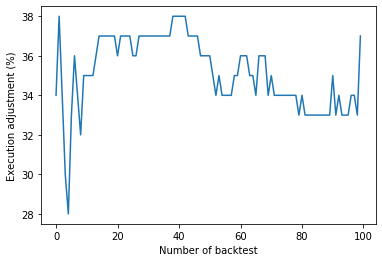

In [20]:
# The best execution of 100 different periods
BestExec = pd.Series(BestExec)
plt.xlabel('Number of backtest')
plt.ylabel('Execution adjustment (%)')
BestExec.plot();

In [21]:
Best_i = BestExec.iloc[-1]
Best_i

37

- Plot all the possible portfolios

In [22]:
cols = []

# List for the results for evaluation
PortfolioReturn = []
StandardDeviation = []
Max = []
Min = []
SharpRatio = []
InformationRatio = []

for i in list(range(0, 51, 1)):
    Return_i = []
    Exec_list_i = list(df_seller_strategy1_ex["Exec_" + str(i) + "%"]) 
    for e in Exec_list_i:
        Return_i.append(e)

    Return_i = pd.Series(Return_i)
    PortfolioReturn.append(Return_i.mean().round(2))
    StandardDeviation.append(Return_i.std().round(2))
    Max.append(Return_i.max().round(2))
    Min.append(Return_i.min().round(2))
    SharpRatio.append((Return_i.mean()/Return_i.std()).round(2))
    InformationRatio.append(round((Return_i - Benchmark_seller).mean()/(Return_i - Benchmark_seller).std(), 3))

    # Make columns names
    cols.append("Exec+" + str(i) + "%")

# Make dataframe for evaluation and  switch columns and row.
df_seller_strategy1_ex_eval = pd.DataFrame()

#各算出結果をdf_portfolio_benchの列へ追加する
df_seller_strategy1_ex_eval["PortfolioReturn"] = pd.Series(PortfolioReturn)
df_seller_strategy1_ex_eval["StandardDeviation"] = pd.Series(StandardDeviation)
df_seller_strategy1_ex_eval["Max"] = pd.Series(Max)
df_seller_strategy1_ex_eval["Min"] = pd.Series(Min)
df_seller_strategy1_ex_eval["SharpRatio"] = pd.Series(SharpRatio)
df_seller_strategy1_ex_eval["InformationRatio"] = pd.Series(InformationRatio)

df_seller_strategy1_ex_eval.index = cols

In [23]:
df_seller_strategy1_ex_eval.head()

,PortfolioReturn,StandardDeviation,Max,Min,SharpRatio,InformationRatio
Exec+0%,9.18,4.71,75.1,0.01,1.95,0.202
Exec+1%,9.19,4.70,75.1,0.01,1.95,0.206
Exec+2%,9.20,4.70,75.1,0.01,1.96,0.210
Exec+3%,9.21,4.68,75.1,0.01,1.97,0.215
Exec+4%,9.22,4.66,75.1,0.01,1.98,0.220


In [24]:
# Pick up the portfolios on the global minimum variance portfolio
std_min = df_seller_strategy1_ex_eval[df_seller_strategy1_ex_eval["StandardDeviation"] == df_seller_strategy1_ex_eval["StandardDeviation"].min()]
GMVP = std_min[std_min["PortfolioReturn"] == std_min["PortfolioReturn"].max()].reset_index()
GMVP

,index,PortfolioReturn,StandardDeviation,Max,Min,SharpRatio,InformationRatio
0,Exec+17%,9.5,4.58,75.1,0.01,2.08,0.317


In [25]:
Best = df_seller_strategy1_ex_eval[df_seller_strategy1_ex_eval["InformationRatio"] == df_seller_strategy1_ex_eval["InformationRatio"].max()]
Best = Best[Best["StandardDeviation"] == Best["StandardDeviation"].min()]
Best

,PortfolioReturn,StandardDeviation,Max,Min,SharpRatio,InformationRatio
Exec+37%,9.9,4.84,75.1,0.01,2.05,0.411


[Global Minimum Variance Portfolio]
Position: DA 73.14%
Expected return: 9.5
Standard deviation: 4.58
Sharp ratio: 2.08
Information ratio: 0.317
[Best Execution Portfolio]
Position: DA 92.51%
Expected return: 9.9
Standard deviation: 4.84
Sharp ratio: 2.05
Information ratio: 0.41


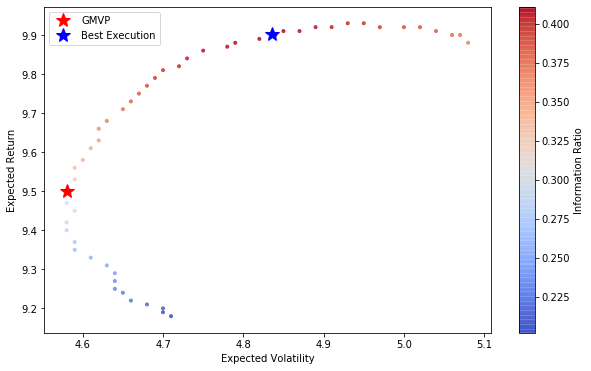

In [26]:
plt.figure(figsize=(10,6))

# Scatter plot all the possible portfolios
plt.scatter(df_seller_strategy1_ex_eval["StandardDeviation"], df_seller_strategy1_ex_eval["PortfolioReturn"], c=df_seller_strategy1_ex_eval["InformationRatio"], marker='.', alpha=0.8, cmap='coolwarm')

# Global minimum variance portfolio
i = 17
DA_position_i = df_seller_strategy1_ex["Position_" + str(i) + "%"].value_counts()[0] 
Intra_position_i = df_seller_strategy1_ex["Position_" + str(i) + "%"].value_counts()[1]

plt.plot(GMVP["StandardDeviation"], GMVP["PortfolioReturn"], 'r*', markersize=15.0, label="GMVP")
print("[Global Minimum Variance Portfolio]")
print("Position: DA {}".format(round(DA_position_i / (DA_position_i+Intra_position_i)*100, 2)) + "%")
print("Expected return: {}".format(GMVP["PortfolioReturn"][0]))
print("Standard deviation: {}".format(GMVP["StandardDeviation"][0]))
print("Sharp ratio: {}".format(GMVP["SharpRatio"][0]))
print("Information ratio: {}".format(GMVP["InformationRatio"][0]))

# The Best Execusion
i = Best_i
DA_position_i = df_seller_strategy1_ex["Position_" + str(i) + "%"].value_counts()[0] 
Intra_position_i = df_seller_strategy1_ex["Position_" + str(i) + "%"].value_counts()[1]

plt.plot(df_seller_strategy1_ex["Exec_" + str(i) + "%"].std(), df_seller_strategy1_ex["Exec_" + str(i) + "%"].mean(), "b*", markersize=15.0, label="Best Execution")
print("[Best Execution Portfolio]")
print("Position: DA {}".format(round(DA_position_i / (DA_position_i+Intra_position_i)*100, 2)) + "%")
print("Expected return: {}".format(df_seller_strategy1_ex["Exec_" + str(i) + "%"].mean().round(2)))
print("Standard deviation: {}".format(df_seller_strategy1_ex["Exec_" + str(i) + "%"].std().round(2)))
print("Sharp ratio: {}".format(round(df_seller_strategy1_ex["Exec_" + str(i) + "%"].mean() / df_seller_strategy1_ex["Exec_" + str(i) + "%"].std(),2)))
print("Information ratio: {}".format(round((df_seller_strategy1_ex["Exec_" + str(i) + "%"] - Benchmark_seller).mean() / (df_seller_strategy1_ex["Exec_" + str(i) + "%"] - Benchmark_seller).std(),2)))

plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Information Ratio')
plt.legend(loc="upper left");

## Strategy 2 (Trading with prediction after DA)
--> Players have the information of spot price and predicted price after DA market <p>
1) Players trade with pre-determined portfolio proportion that ranges from 0% to 100%. <p>
2) Positions are derived with execution range if players have the possition of intraday market <p>

### Required dataset

In [27]:
# Need predicted price after DA market and spot price
df_seller_strategy2 = df_prediction_afterDA.copy()

# Make lists for price information
Spot_list = list(df_seller_strategy2["Spot"])
High_list = list(df_seller_strategy2["High"])
Close_list = list(df_seller_strategy2["Close"])
Pred_list_i = list(df_seller_strategy2["Close_pred"])
# Judge_success = []
                   
# list for executed orders
Executed_i = []
# list for checking the execution results
Judge_i = []    
                   
# Calculate executed price
for h, c, p in zip(High_list, Close_list, Pred_list_i):     
    # Trade on Intra markets
    if p <= h:
        Executed_i.append(p)
        Judge_i.append("True")
    else:
        Executed_i.append(c)
        Judge_i.append("False")                 

df_seller_strategy2["ExecutedOrder"] = pd.Series(Executed_i)
df_seller_strategy2["Judge"] = pd.Series(Judge_i)

df_seller_strategy2.tail()

,DateTime,Spot,High,Low,Close,Close_pred,ExecutedOrder,Judge
59515,2020-12-31 21:30:00,35.0,70.0,33.00,70.00,27.89,27.89,True
59516,2020-12-31 22:00:00,45.0,70.0,41.01,45.48,32.48,32.48,True
59517,2020-12-31 22:30:00,40.0,70.0,35.00,41.33,28.67,28.67,True
59518,2020-12-31 23:00:00,35.0,70.0,33.93,36.66,25.51,25.51,True
59519,2020-12-31 23:30:00,25.0,37.5,23.93,26.46,19.23,19.23,True


### Evaluation

In [28]:
portfolio_weights= [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

cols = []

Return = [] 
PortfolioReturn = []
StandardDeviation = []
SharpRatio = []
InformationRatio = []

Spot_list = list(df_seller_strategy2["Spot"])
Exec_list = list(df_seller_strategy2["ExecutedOrder"])

for weight in portfolio_weights:
    Return = []
    for spot, intra in zip(Spot_list, Exec_list):
        # DA market 100%
        if weight == 1.0:
            Return.append(spot*weight)
        # Trade both on DA and Intra day
        else:
            Return.append(spot*weight + intra*(1-weight))
    # Set colmun name
    cols.append("DA" + str(weight*100) + "%")

    # Results
    Return = pd.Series(Return)
    PortfolioReturn.append(Return.mean().round(2))
    StandardDeviation.append(Return.std().round(2))
    SharpRatio.append((Return.mean()/Return.std()).round(2))
    InformationRatio.append(round((Return - Benchmark_seller).mean() / (Return - Benchmark_seller).std(), 3))
    
# Transpose columns and rows
df_seller_strategy2_eval = pd.DataFrame()
df_seller_strategy2_eval = df_seller_strategy2_eval.T

# Add columns for evaluation metrics
df_seller_strategy2_eval["PortfolioReturn"] = pd.Series(PortfolioReturn)
df_seller_strategy2_eval["StandardDeviation"] = pd.Series(StandardDeviation)
df_seller_strategy2_eval["Max"] = pd.Series(Max)
df_seller_strategy2_eval["Min"] = pd.Series(Min)
df_seller_strategy2_eval["SharpRatio"] = pd.Series(SharpRatio)
df_seller_strategy2_eval["InformationRatio"] = pd.Series(InformationRatio)
df_seller_strategy2_eval.index = cols

In [29]:
df_seller_strategy2_eval

,PortfolioReturn,StandardDeviation,Max,Min,SharpRatio,InformationRatio
DA0%,8.30,3.56,75.1,0.01,2.33,-0.195
DA10.0%,8.33,3.65,75.1,0.01,2.28,-0.195
DA20.0%,8.35,3.74,75.1,0.01,2.23,-0.195
DA30.0%,8.37,3.83,75.1,0.01,2.18,-0.195
DA40.0%,8.40,3.93,75.1,0.01,2.14,-0.195
DA50.0%,8.42,4.02,75.1,0.01,2.09,-0.195
DA60.0%,8.44,4.12,75.1,0.01,2.05,-0.195
DA70.0%,8.46,4.21,75.1,0.01,2.01,-0.195
DA80.0%,8.49,4.31,75.1,0.01,1.97,-0.195
DA90.0%,8.51,4.41,75.1,0.01,1.93,-0.195


In [30]:
# Pick up the portfolios on the global minimum variance portfolio
std_min = df_seller_strategy2_eval[df_seller_strategy2_eval["StandardDeviation"] == df_seller_strategy2_eval["StandardDeviation"].min()]
GMVP = std_min[std_min["PortfolioReturn"] == std_min["PortfolioReturn"].max()].reset_index()
GMVP

,index,PortfolioReturn,StandardDeviation,Max,Min,SharpRatio,InformationRatio
0,DA0%,8.3,3.56,75.1,0.01,2.33,-0.195


In [31]:
# Pick up the best portrolio
Best = df_seller_strategy2_eval[df_seller_strategy2_eval["InformationRatio"] == df_seller_strategy2_eval["InformationRatio"].max()]
Best = Best[Best["StandardDeviation"] == Best["StandardDeviation"].min()]
Best

,PortfolioReturn,StandardDeviation,Max,Min,SharpRatio,InformationRatio
DA0%,8.3,3.56,75.1,0.01,2.33,-0.195


[Global Minimum Variance Portfolio]
Expected return: 8.3
Standard deviation: 3.56
Sharp ratio: 2.33
Information ratio: -0.195
[Best Execution Portfolio]
Expected return: 8.3
Standard deviation: 3.56
Sharp ratio: 2.33
Information ratio: -0.195


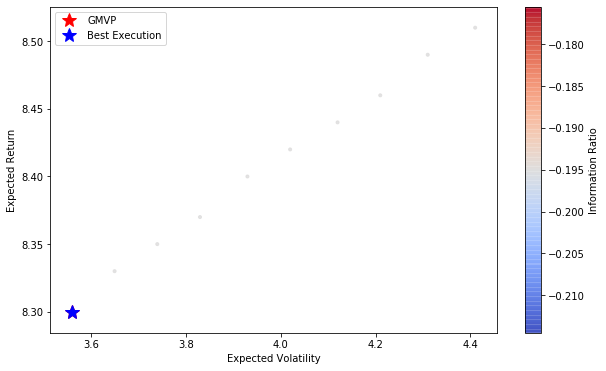

In [32]:
plt.figure(figsize=(10,6))

# Scatter plot all the possible portfolios
plt.scatter(df_seller_strategy2_eval["StandardDeviation"], df_seller_strategy2_eval["PortfolioReturn"], c=df_seller_strategy2_eval["InformationRatio"], marker='.', alpha=0.8, cmap='coolwarm')

# Global minimum variance portfolio
plt.plot(GMVP["StandardDeviation"], GMVP["PortfolioReturn"], 'r*', markersize=15.0, label="GMVP")
print("[Global Minimum Variance Portfolio]")
print("Expected return: {}".format(GMVP["PortfolioReturn"][0]))
print("Standard deviation: {}".format(GMVP["StandardDeviation"][0]))
print("Sharp ratio: {}".format(GMVP["SharpRatio"][0]))
print("Information ratio: {}".format(GMVP["InformationRatio"][0]))

# The Best Execusion
plt.plot(Best["StandardDeviation"], Best["PortfolioReturn"], "b*", markersize=15.0, label="Best Execution")
print("[Best Execution Portfolio]")
print("Expected return: {}".format(Best["PortfolioReturn"][0]))
print("Standard deviation: {}".format(Best["StandardDeviation"][0]))
print("Sharp ratio: {}".format(Best["SharpRatio"][0]))
print("Information ratio: {}".format(Best["InformationRatio"][0]))

plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Information Ratio')
plt.legend(loc="upper left");

## Strategy 2 with execusion strategy
--> Players have the information of spot price and predicted price after DA market <p>
1) Players trade with pre-determined portfolio proportion that ranges from 0% to 100%. <p>
2) Positions is derived with execution range if players have the possition of intraday market <p>

### Required dataset

In [33]:
# Need predicted price after DA market and spot price
df_seller_strategy2_ex = df_prediction_beforeDA.copy()

# Make lists for price information
Spot_list = list(df_seller_strategy2_ex["Spot"])
High_list = list(df_seller_strategy2_ex["High"])
Close_list = list(df_seller_strategy2_ex["Close"])

# Order and execution with execusion range
for i in list(range(0, 51, 1)):
    # list for executed orders
    Executed_i = []
    # list for checking the execution results
    Judge_i = []    
    # Derive the predicted price with the range
    Pred_list_i = list((df_seller_strategy2_ex["Close_pred"]* (1 + i/100)).round(2))
    for h, c, p in zip(High_list, Close_list, Pred_list_i):     
        # Trade on Intra markets
        if p <= h:
            Executed_i.append(p)
            Judge_i.append("True")
        else:
            Executed_i.append(c)
            Judge_i.append("False")                 
                
    df_seller_strategy2_ex["Exec_" + str(i) + "%"] = pd.Series(Executed_i)
    df_seller_strategy2_ex["Judge_" + str(i) + "%"] = pd.Series(Judge_i)

In [34]:
df_seller_strategy2_ex.tail()

,Date,HH,Open,High,Low,Close,Spot,Spot_1daylag,DateTime,Close_pred,Exec_0%,Judge_0%,Exec_1%,Judge_1%,Exec_2%,Judge_2%,Exec_3%,Judge_3%,Exec_4%,Judge_4%,Exec_5%,Judge_5%,Exec_6%,Judge_6%,Exec_7%,Judge_7%,Exec_8%,Judge_8%,Exec_9%,Judge_9%,Exec_10%,Judge_10%,Exec_11%,Judge_11%,Exec_12%,Judge_12%,Exec_13%,Judge_13%,Exec_14%,Judge_14%,Exec_15%,Judge_15%,Exec_16%,Judge_16%,Exec_17%,Judge_17%,Exec_18%,Judge_18%,Exec_19%,Judge_19%,Exec_20%,Judge_20%,Exec_21%,Judge_21%,Exec_22%,Judge_22%,Exec_23%,Judge_23%,Exec_24%,Judge_24%,Exec_25%,Judge_25%,Exec_26%,Judge_26%,Exec_27%,Judge_27%,Exec_28%,Judge_28%,Exec_29%,Judge_29%,Exec_30%,Judge_30%,Exec_31%,Judge_31%,Exec_32%,Judge_32%,Exec_33%,Judge_33%,Exec_34%,Judge_34%,Exec_35%,Judge_35%,Exec_36%,Judge_36%,Exec_37%,Judge_37%,Exec_38%,Judge_38%,Exec_39%,Judge_39%,Exec_40%,Judge_40%,Exec_41%,Judge_41%,Exec_42%,Judge_42%,Exec_43%,Judge_43%,Exec_44%,Judge_44%,Exec_45%,Judge_45%,Exec_46%,Judge_46%,Exec_47%,Judge_47%,Exec_48%,Judge_48%,Exec_49%,Judge_49%,Exec_50%,Judge_50%
59515,2020-12-31,44,35.0,70.0,33.00,70.00,35.0,50.00,2020-12-31 21:30:00,18.81,18.81,True,19.00,True,19.19,True,19.37,True,19.56,True,19.75,True,19.94,True,20.13,True,20.31,True,20.50,True,20.69,True,20.88,True,21.07,True,21.26,True,21.44,True,21.63,True,21.82,True,22.01,True,22.20,True,22.38,True,22.57,True,22.76,True,22.95,True,23.14,True,23.32,True,23.51,True,23.70,True,23.89,True,24.08,True,24.26,True,24.45,True,24.64,True,24.83,True,25.02,True,25.21,True,25.39,True,25.58,True,25.77,True,25.96,True,26.15,True,26.33,True,26.52,True,26.71,True,26.90,True,27.09,True,27.27,True,27.46,True,27.65,True,27.84,True,28.03,True,28.21,True
59516,2020-12-31,45,42.0,70.0,41.01,45.48,40.0,40.00,2020-12-31 22:00:00,19.55,19.55,True,19.75,True,19.94,True,20.14,True,20.33,True,20.53,True,20.72,True,20.92,True,21.11,True,21.31,True,21.51,True,21.70,True,21.90,True,22.09,True,22.29,True,22.48,True,22.68,True,22.87,True,23.07,True,23.26,True,23.46,True,23.66,True,23.85,True,24.05,True,24.24,True,24.44,True,24.63,True,24.83,True,25.02,True,25.22,True,25.42,True,25.61,True,25.81,True,26.00,True,26.20,True,26.39,True,26.59,True,26.78,True,26.98,True,27.17,True,27.37,True,27.57,True,27.76,True,27.96,True,28.15,True,28.35,True,28.54,True,28.74,True,28.93,True,29.13,True,29.33,True
59517,2020-12-31,46,42.0,70.0,35.00,41.33,40.0,40.00,2020-12-31 22:30:00,17.98,17.98,True,18.16,True,18.34,True,18.52,True,18.70,True,18.88,True,19.06,True,19.24,True,19.42,True,19.60,True,19.78,True,19.96,True,20.14,True,20.32,True,20.50,True,20.68,True,20.86,True,21.04,True,21.22,True,21.40,True,21.58,True,21.76,True,21.94,True,22.12,True,22.30,True,22.48,True,22.65,True,22.83,True,23.01,True,23.19,True,23.37,True,23.55,True,23.73,True,23.91,True,24.09,True,24.27,True,24.45,True,24.63,True,24.81,True,24.99,True,25.17,True,25.35,True,25.53,True,25.71,True,25.89,True,26.07,True,26.25,True,26.43,True,26.61,True,26.79,True,26.97,True
59518,2020-12-31,47,37.0,70.0,33.93,36.66,35.0,33.21,2020-12-31 23:00:00,14.78,14.78,True,14.93,True,15.08,True,15.22,True,15.37,True,15.52,True,15.67,True,15.81,True,15.96,True,16.11,True,16.26,True,16.41,True,16.55,True,16.70,True,16.85,True,17.00,True,17.14,True,17.29,True,17.44,True,17.59,True,17.74,True,17.88,True,18.03,True,18.18,True,18.33,True,18.47,True,18.62,True,18.77,True,18.92,True,19.07,True,19.21,True,19.36,True,19.51,True,19.66,True,19.81,True,19.95,True,20.10,True,20.25,True,20.40,True,20.54,True,20.69,True,20.84,True,20.99,True,21.14,True,21.28,True,21.43,True,21.58,True,21.73,True,21.87,True,22.02,True,22.17,True
59519,2020-12-31,48,27.0,37.5,23.93,26.46,25.0,25.00,2020-12-31 23:30:00,12.57,12.57,True,12.70,True,12.82,True,12.95,True,13.07,True,13.20,True,13.32,True,13.45,True,13.58,True,13.70,True,13.83,True,13.95,True,14.08,True,14.20,True,14.33,True,14.46,True,14.58,True,14.71,True,14.83,True,14.96,True,15.08,True,15.21,True,15.34,True,15.46,True,15.59,True,15.71,True,15.84,True,15.96,True,16.09,True,16.22,True,16.34,True,16.4

### Evaluation

- Look for the best execution

In [35]:
n_splits=100

train_size = df_seller_strategy2_ex.index[-1]
sample_size = int(train_size/n_splits)
train_index_list = list(np.linspace(sample_size, train_size, n_splits, endpoint = True, dtype='int'))
train_index_list

# # Confirming the split logic
# for train_index in train_index_list:
#     # Divide the train/valid set  into 10 folds and pick up it.
#     X_train = df_seller_strategy2_ex.iloc[:train_index]
#     print("start:", train_index - sample_size)
#     print("end:", train_index)

[595,
 1190,
 1785,
 2380,
 2975,
 3570,
 4166,
 4761,
 5356,
 5951,
 6546,
 7142,
 7737,
 8332,
 8927,
 9522,
 10118,
 10713,
 11308,
 11903,
 12498,
 13094,
 13689,
 14284,
 14879,
 15474,
 16069,
 16665,
 17260,
 17855,
 18450,
 19045,
 19641,
 20236,
 20831,
 21426,
 22021,
 22617,
 23212,
 23807,
 24402,
 24997,
 25593,
 26188,
 26783,
 27378,
 27973,
 28569,
 29164,
 29759,
 30354,
 30949,
 31544,
 32140,
 32735,
 33330,
 33925,
 34520,
 35116,
 35711,
 36306,
 36901,
 37496,
 38092,
 38687,
 39282,
 39877,
 40472,
 41068,
 41663,
 42258,
 42853,
 43448,
 44044,
 44639,
 45234,
 45829,
 46424,
 47019,
 47615,
 48210,
 48805,
 49400,
 49995,
 50591,
 51186,
 51781,
 52376,
 52971,
 53567,
 54162,
 54757,
 55352,
 55947,
 56543,
 57138,
 57733,
 58328,
 58923,
 59519]

In [36]:
# This code is used only for confirming the best execution point
BestExec = []

for train_index in train_index_list:
    X_train = df_seller_strategy2_ex[:train_index]
    Spot_list = list(X_train["Spot"])
   
    cols = []
    PortfolioReturn = []
    StandardDeviation = []
    SharpRatio = []
    InformationRatio = []
    
    portfolio_weights= [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    
    for i in list(range(0, 51, 1)):
        for weight in portfolio_weights:
            Return_iw = []
            Exec_list = list(X_train["Exec_" + str(i) + "%"])
            for spot, intra in zip(Spot_list, Exec_list):
                # DA market 100%
                if weight == 1.0:
                    Return_iw.append(spot*weight)
                # Trade both on DA and Intra day
                else:
                    Return_iw.append(spot*weight + intra*(1-weight))
            # Set colmun name
            if weight == 1.0:
                cols.append(str(0))
            else:
                cols.append(str(i))

            # Results
            Return_iw = pd.Series(Return_iw)
            PortfolioReturn.append(Return_iw.mean().round(2))
            StandardDeviation.append(Return_iw.std().round(2))
            SharpRatio.append((Return_iw.mean()/Return_iw.std()).round(2))
            InformationRatio.append(round((Return_iw - Benchmark_seller).mean() / (Return_iw - Benchmark_seller).std(), 3))

    # Results of every portfolios derived by execution strateties
    df_seller_strategy2_ex_eval = pd.DataFrame()
    df_seller_strategy2_ex_eval = df_seller_strategy2_ex_eval.T

    # Add columns for evaluation metrics
    df_seller_strategy2_ex_eval["PortfolioReturn"] = pd.Series(PortfolioReturn)
    df_seller_strategy2_ex_eval["StandardDeviation"] = pd.Series(StandardDeviation)
    df_seller_strategy2_ex_eval["SharpRatio"] = pd.Series(SharpRatio)
    df_seller_strategy2_ex_eval["InformationRatio"] = pd.Series(InformationRatio)

    df_seller_strategy2_ex_eval.index = cols
    df_seller_strategy2_ex_eval = df_seller_strategy2_ex_eval.reset_index()
    df_seller_strategy2_ex_eval = df_seller_strategy2_ex_eval.rename(columns={"index": "ExecBuffer(%)"})

    Exec = df_seller_strategy2_ex_eval[df_seller_strategy2_ex_eval["InformationRatio"] == df_seller_strategy2_ex_eval["InformationRatio"].max()]
    Exec = Exec["ExecBuffer(%)"][Exec["StandardDeviation"] == Exec["StandardDeviation"].min()].iloc[0]
    BestExec.append(Exec)

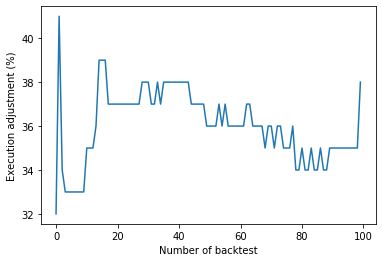

In [37]:
BestExec = pd.Series(BestExec).astype(int)
plt.xlabel('Number of backtest')
plt.ylabel('Execution adjustment (%)')
BestExec.plot();

In [38]:
Best_i = BestExec.iloc[-1]
Best_i

38

- Plot all the possible portfolios

In [39]:
Spot_list = list(df_seller_strategy2_ex["Spot"])

portfolio_weights= [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
execution_buffers = list(range(0, 51, 1))

cols = []

Return = [] 
PortfolioReturn = []
StandardDeviation = []
SharpRatio = []
InformationRatio = []

for i in execution_buffers:
    Exec_list = list(df_seller_strategy2_ex["Exec_" + str(i) + "%"])
    for weight in portfolio_weights:
        Return_iw = []
        for spot, intra in zip(Spot_list, Exec_list):
            # DA market 100%
            if weight == 1.0:
                Return_iw.append(spot*weight)
            # Trade both on DA and Intra day
            else:
                Return_iw.append(spot*weight + intra*(1-weight))
        # Set colmun name for execution buffer
        if weight == 1.0:
            cols.append("DA100%")
        else:
            cols.append("DA" + str(weight*100) + "%_Exec+" + str(i) + "%")

        # Results
        Return_iw = pd.Series(Return_iw)
        PortfolioReturn.append(Return_iw.mean().round(2))
        StandardDeviation.append(Return_iw.std().round(2))
        SharpRatio.append((Return_iw.mean()/Return_iw.std()).round(2))
        InformationRatio.append(round((Return_iw - Benchmark_seller).mean() / (Return_iw - Benchmark_seller).std(), 3))

# Transpose columns and rows
df_seller_strategy2_ex_eval = pd.DataFrame()
df_seller_strategy2_ex_eval = df_seller_strategy2_ex_eval.T

# Add columns for evaluation metrics
df_seller_strategy2_ex_eval["PortfolioReturn"] = pd.Series(PortfolioReturn)
df_seller_strategy2_ex_eval["StandardDeviation"] = pd.Series(StandardDeviation)
df_seller_strategy2_ex_eval["SharpRatio"] = pd.Series(SharpRatio)
df_seller_strategy2_ex_eval["InformationRatio"] = pd.Series(InformationRatio)

df_seller_strategy2_ex_eval.index = cols

In [40]:
# Pick up the portfolios on the global minimum variance portfolio
std_min = df_seller_strategy2_ex_eval[df_seller_strategy2_ex_eval["StandardDeviation"] == df_seller_strategy2_ex_eval["StandardDeviation"].min()]
GMVP = std_min[std_min["PortfolioReturn"] == std_min["PortfolioReturn"].max()].reset_index()
GMVP

,index,PortfolioReturn,StandardDeviation,SharpRatio,InformationRatio
0,DA0%_Exec+0%,8.2,2.62,3.13,-0.117


In [41]:
# Pick up the best portfolio
Best = df_seller_strategy2_ex_eval[df_seller_strategy2_ex_eval["InformationRatio"] == df_seller_strategy2_ex_eval["InformationRatio"].max()]
Best = Best[Best["StandardDeviation"] == Best["StandardDeviation"].min()]
Best

,PortfolioReturn,StandardDeviation,SharpRatio,InformationRatio
DA50.0%_Exec+38%,9.52,4.25,2.24,0.521


[Global Minimum Variance Portfolio: 0]
Expected return: 8.2
Standard deviation: 2.62
Sharp ratio: 3.13
Information ratio: -0.117
[Best Execution Portfolio: 0.5%_Exec+38%]
Expected return: 9.52
Standard deviation: 4.25
Sharp ratio: 2.24
Information ratio: 0.521


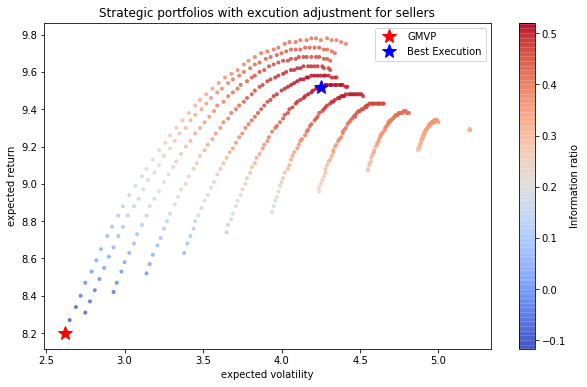

In [42]:
plt.figure(figsize=(10,6))

# Scatter plot all the possible portfolios
plt.scatter(df_seller_strategy2_ex_eval["StandardDeviation"], df_seller_strategy2_ex_eval["PortfolioReturn"], c=df_seller_strategy2_ex_eval["InformationRatio"], marker='.', alpha=0.8, cmap='coolwarm')

# Global minimum variance portfolio
plt.plot(GMVP["StandardDeviation"], GMVP["PortfolioReturn"], 'r*', markersize=15.0, label="GMVP")
print("[Global Minimum Variance Portfolio: " + str(GMVP.index[0]) + "]")
print("Expected return: {}".format(GMVP["PortfolioReturn"][0]))
print("Standard deviation: {}".format(GMVP["StandardDeviation"][0]))
print("Sharp ratio: {}".format(GMVP["SharpRatio"][0]))
print("Information ratio: {}".format(GMVP["InformationRatio"][0]))

# The Best Execusion
DA_weight = 0.5
i = Best_i
Best_Portfolio = (DA_weight * df_seller_strategy2_ex["Spot"]) + ((1 - DA_weight) * df_seller_strategy2_ex["Exec_" + str(i) + "%"])
plt.plot(Best_Portfolio.std(), Best_Portfolio.mean(), "b*", markersize=15.0, label="Best Execution")
print("[Best Execution Portfolio: " + str(DA_weight) + "%_Exec+" + str(i) + "%]")
print("Expected return: {}".format(Best_Portfolio.mean().round(2)))
print("Standard deviation: {}".format(Best_Portfolio.std().round(2)))
print("Sharp ratio: {}".format(round(Best_Portfolio.mean() / Best_Portfolio.std(), 2)))
print("Information ratio: {}".format(round((Best_Portfolio - Benchmark_seller).mean() / (Best_Portfolio - Benchmark_seller).std(), 3)))

plt.title('Strategic portfolios with excution adjustment for sellers')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Information ratio')
plt.legend(loc="upper right");

# Trading strategy for buyers (e.g. retailers)
- Basically the same as the strategies for seller
- Buyer aims to buy for cheaper price

In [43]:
# Benchmark for buyer's strategy
Benchmark_buyer = -df_benchmark1["Spot"].round(2)
Benchmark_buyer

0        -7.98
1        -7.67
2        -6.86
3        -6.58
4        -6.62
         ...  
59515   -35.00
59516   -45.00
59517   -40.00
59518   -35.00
59519   -25.00
Name: Spot, Length: 59520, dtype: float64

## Strategy 1 (Trading with prediction before DA) without execution strategy

### Required dataset

In [44]:
# Need predicted price before DA market and 1 dayahead spot price
df_buyer_strategy1 = df_prediction_beforeDA.copy()
df_buyer_strategy1["Spot_1dayahead"] = df_buyer_strategy1["Spot"].shift(48)
# Drop rows that include NaN
df_buyer_strategy1 = df_buyer_strategy1.dropna(how='any', axis=0).reset_index(drop=True)

# Make lists for price information
SpotLag_list= list(df_buyer_strategy1["Spot_1dayahead"])
Spot_list = list(df_buyer_strategy1["Spot"])
Low_list = list(df_buyer_strategy1["Low"])
Close_list = list(df_buyer_strategy1["Close"])
Pred_list = list(df_buyer_strategy1["Close_pred"])
# Judge_success = []

# list for executed orders
Executed = []
Judge = []
Position = []
for sl, s, l, c, p  in zip(SpotLag_list, Spot_list, Low_list, Close_list, Pred_list):
    # Trade on DA market
    if sl <= p:
        Executed.append(-s)
        Judge.append("True")
        Position.append("DA") 
    # Trade on Intra markets
    else:
        if p <= l:
            Executed.append(-p)
            Judge.append("True")
            Position.append("Intra") 
        else:
            Executed.append(-c)
            Judge.append("False")  
            Position.append("Intra") 

df_buyer_strategy1["ExecutedOrder"] = pd.Series(Executed)
df_buyer_strategy1["Judge"] = pd.Series(Judge)
df_buyer_strategy1["Position"] = pd.Series(Position)

df_buyer_strategy1.tail()

,Date,HH,Open,High,Low,Close,Spot,Spot_1daylag,DateTime,Close_pred,Spot_1dayahead,ExecutedOrder,Judge,Position
59467,2020-12-31,44,35.0,70.0,33.00,70.00,35.0,50.00,2020-12-31 21:30:00,18.81,50.00,-18.81,True,Intra
59468,2020-12-31,45,42.0,70.0,41.01,45.48,40.0,40.00,2020-12-31 22:00:00,19.55,40.00,-19.55,True,Intra
59469,2020-12-31,46,42.0,70.0,35.00,41.33,40.0,40.00,2020-12-31 22:30:00,17.98,40.00,-17.98,True,Intra
59470,2020-12-31,47,37.0,70.0,33.93,36.66,35.0,33.21,2020-12-31 23:00:00,14.78,33.21,-14.78,True,Intra
59471,2020-12-31,48,27.0,37.5,23.93,26.46,25.0,25.00,2020-12-31 23:30:00,12.57,25.00,-12.57,True,Intra


### Evaluation

In [45]:
# The percentage of DA position
DA_position = df_buyer_strategy1["Position"].value_counts()[0] 
Intra_position = df_buyer_strategy1["Position"].value_counts()[1]
DA_ratio = round(DA_position / (DA_position+Intra_position)*100, 2)
DA_ratio

63.82

Position: DA 63.82%
Expected return: -8.31
Standard deviation: 4.24
Sharp ratio: -1.96
Information ratio: 0.052


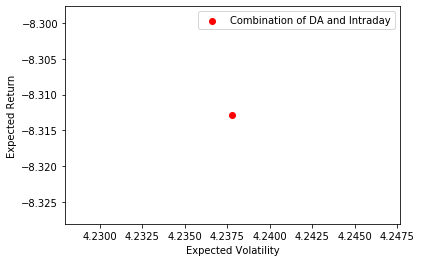

In [46]:
# fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
plt.scatter(x=df_buyer_strategy1["ExecutedOrder"].std(), y=df_buyer_strategy1["ExecutedOrder"].mean(), color="r", label="Combination of DA and Intraday")
print("Position: DA {}".format(round(DA_position / (DA_position+Intra_position)*100, 2)) + "%")
print("Expected return: {}".format(df_buyer_strategy1["ExecutedOrder"].mean().round(2)))
print("Standard deviation: {}".format(df_buyer_strategy1["ExecutedOrder"].std().round(2)))
print("Sharp ratio: {}".format(round(df_buyer_strategy1["ExecutedOrder"].mean()/df_buyer_strategy1["ExecutedOrder"].std(),2)))
print("Information ratio: {}".format(round((df_buyer_strategy1["ExecutedOrder"] - Benchmark_buyer).mean() / (df_buyer_strategy1["ExecutedOrder"] - Benchmark_buyer).std(),3)))

plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.legend();

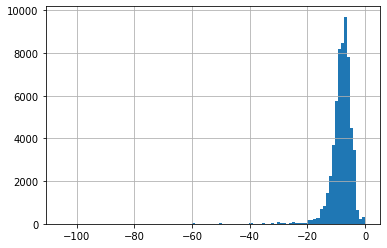

In [47]:
df_buyer_strategy1["ExecutedOrder"].hist(bins=100);

## Strategy 1 with execusion strategy

### Required dataset

In [48]:
# Need predicted price before DA market and 1 dayahead spot price
df_buyer_strategy1_ex = df_prediction_beforeDA.copy()
df_buyer_strategy1_ex["Spot_1dayahead"] = df_buyer_strategy1_ex["Spot"].shift(48)
# Drop rows that include NaN
df_buyer_strategy1_ex = df_buyer_strategy1_ex.dropna(how='any', axis=0).reset_index(drop=True)

# Make lists for price information
SpotLag_list= list(df_buyer_strategy1_ex["Spot_1dayahead"])
Spot_list = list(df_buyer_strategy1_ex["Spot"])
Low_list = list(df_buyer_strategy1_ex["Low"])
Close_list = list(df_buyer_strategy1_ex["Close"])
# Judge_success = []

# Order and execution with execusion range
for i in list(range(0, 51, 1)):
    # list for executed orders
    Executed_i = []
    # list for checking the execution results
    Judge_i = []    
    Position_i = []
    # Derive the predicted price with the range from +0% ~ +20%
    Pred_list_i = list((df_buyer_strategy1_ex["Close_pred"]* (1 - i/100)).round(2))
    for sl, s, l, c, p in zip(SpotLag_list, Spot_list, Low_list, Close_list, Pred_list_i):
        # Trade on DA market
        if sl <= p:
            Executed_i.append(-s)
            Judge_i.append("True")
            Position_i.append("DA")
        # Trade on Intra markets
        else:
            if p >= l:
                Executed_i.append(-p)
                Judge_i.append("True")
                Position_i.append("Intra")
            else:
                Executed_i.append(-c)
                Judge_i.append("False")           
                Position_i.append("Intra")

    df_buyer_strategy1_ex["Exec_" + str(i) + "%"] = pd.Series(Executed_i)
    df_buyer_strategy1_ex["Judge_" + str(i) + "%"] = pd.Series(Judge_i)
    df_buyer_strategy1_ex["Position_" + str(i) + "%"] = pd.Series(Position_i)
    
df_buyer_strategy1_ex.head()

,Date,HH,Open,High,Low,Close,Spot,Spot_1daylag,DateTime,Close_pred,Spot_1dayahead,Exec_0%,Judge_0%,Position_0%,Exec_1%,Judge_1%,Position_1%,Exec_2%,Judge_2%,Position_2%,Exec_3%,Judge_3%,Position_3%,Exec_4%,Judge_4%,Position_4%,Exec_5%,Judge_5%,Position_5%,Exec_6%,Judge_6%,Position_6%,Exec_7%,Judge_7%,Position_7%,Exec_8%,Judge_8%,Position_8%,Exec_9%,Judge_9%,Position_9%,Exec_10%,Judge_10%,Position_10%,Exec_11%,Judge_11%,Position_11%,Exec_12%,Judge_12%,Position_12%,Exec_13%,Judge_13%,Position_13%,Exec_14%,Judge_14%,Position_14%,Exec_15%,Judge_15%,Position_15%,Exec_16%,Judge_16%,Position_16%,Exec_17%,Judge_17%,Position_17%,Exec_18%,Judge_18%,Position_18%,Exec_19%,Judge_19%,Position_19%,Exec_20%,Judge_20%,Position_20%,Exec_21%,Judge_21%,Position_21%,Exec_22%,Judge_22%,Position_22%,Exec_23%,Judge_23%,Position_23%,Exec_24%,Judge_24%,Position_24%,Exec_25%,Judge_25%,Position_25%,Exec_26%,Judge_26%,Position_26%,Exec_27%,Judge_27%,Position_27%,Exec_28%,Judge_28%,Position_28%,Exec_29%,Judge_29%,Position_29%,Exec_30%,Judge_30%,Position_30%,Exec_31%,Judge_31%,Position_31%,Exec_32%,Judge_32%,Position_32%,Exec_33%,Judge_33%,Position_33%,Exec_34%,Judge_34%,Position_34%,Exec_35%,Judge_35%,Position_35%,Exec_36%,Judge_36%,Position_36%,Exec_37%,Judge_37%,Position_37%,Exec_38%,Judge_38%,Position_38%,Exec_39%,Judge_39%,Position_39%,Exec_40%,Judge_40%,Position_40%,Exec_41%,Judge_41%,Position_41%,Exec_42%,Judge_42%,Position_42%,Exec_43%,Judge_43%,Position_43%,Exec_44%,Judge_44%,Position_44%,Exec_45%,Judge_45%,Position_45%,Exec_46%,Judge_46%,Position_46%,Exec_47%,Judge_47%,Position_47%,Exec_48%,Judge_48%,Position_48%,Exec_49%,Judge_49%,Position_49%,Exec_50%,Judge_50%,Position_50%
0,2017-08-11,1,6.86,11.50,5.39,7.41,7.74,8.19,2017-08-11 00:00:00,7.55,8.19,-7.55,True,Intra,-7.47,True,Intra,-7.40,True,Intra,-7.32,True,Intra,-7.25,True,Intra,-7.17,True,Intra,-7.10,True,Intra,-7.02,True,Intra,-6.95,True,Intra,-6.87,True,Intra,-6.80,True,Intra,-6.72,True,Intra,-6.64,True,Intra,-6.57,True,Intra,-6.49,True,Intra,-6.42,True,Intra,-6.34,True,Intra,-6.27,True,Intra,-6.19,True,Intra,-6.12,True,Intra,-6.04,True,Intra,-5.96,True,Intra,-5.89,True,Intra,-5.81,True,Intra,-5.74,True,Intra,-5.66,True,Intra,-5.59,True,Intra,-5.51,True,Intra,-5.44,True,Intra,-7.41,False,Intra,-7.41,False,Intra,-7.41,False,Intra,-7.41,False,Intra,-7.41,False,Intra,-7.41,False,Intra,-7.41,False,Intra,-7.41,False,Intra,-7.41,False,Intra,-7.41,False,Intra,-7.41,False,Intra,-7.41,False,Intra,-7.41,False,Intra,-7.41,False,Intra,-7.41,False,Intra,-7.41,False,Intra,-7.41,False,Intra,-7.41,False,Intra,-7.41,False,Intra,-7.41,False,Intra,-7.41,False,Intra,-7.41,False,Intra
1,2017-08-11,2,10.71,10.71,6.06,6.50,6.71,8.04,2017-08-11 00:30:00,7.48,8.04,-7.48,True,Intra,-7.41,True,Intra,-7.33,True,Intra,-7.26,True,Intra,-7.18,True,Intra,-7.11,True,Intra,-7.03,True,Intra,-6.96,True,Intra,-6.88,True,Intra,-6.81,True,Intra,-6.73,True,Intra,-6.66,True,Intra,-6.58,True,Intra,-6.51,True,Intra,-6.43,True,Intra,-6.36,True,Intra,-6.28,True,Intra,-6.21,True,Intra,-6.13,True,Intra,-6.06,True,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra,-6.50,False,Intra
2,2017-08-11,3,10.23,10.23,5.76,6.02,6.24,7.93,2017-08-11 01:00:00,7.12,7.93,-7.12,True,Intra,-7.05,True,Intra,-6.98,True,Intra,-6.91,True,Intra,-6.84,True,Intra,-6.76,True,Intra,-6.69,True,Intra,-6.62,True,Intra,-6.55,True,Intra,-6.48,True,Intra,-6.41,True,Intra,-6.34,True,Intra,-6.27,True,Intra,-6.19,True,Intra,-6.12,True,Intra,-6.05,True,Intra,-5.98,True,Intra,-5.91,True

### Evaluation

In [49]:
n_splits=100

train_size = df_buyer_strategy1_ex.index[-1]
train_index_list = list(np.linspace(train_size/n_splits, train_size, n_splits, endpoint = True, dtype='int'))
train_index_list

[594,
 1189,
 1784,
 2378,
 2973,
 3568,
 4162,
 4757,
 5352,
 5947,
 6541,
 7136,
 7731,
 8325,
 8920,
 9515,
 10110,
 10704,
 11299,
 11894,
 12488,
 13083,
 13678,
 14273,
 14867,
 15462,
 16057,
 16651,
 17246,
 17841,
 18436,
 19030,
 19625,
 20220,
 20814,
 21409,
 22004,
 22598,
 23193,
 23788,
 24383,
 24977,
 25572,
 26167,
 26761,
 27356,
 27951,
 28546,
 29140,
 29735,
 30330,
 30924,
 31519,
 32114,
 32709,
 33303,
 33898,
 34493,
 35087,
 35682,
 36277,
 36872,
 37466,
 38061,
 38656,
 39250,
 39845,
 40440,
 41034,
 41629,
 42224,
 42819,
 43413,
 44008,
 44603,
 45197,
 45792,
 46387,
 46982,
 47576,
 48171,
 48766,
 49360,
 49955,
 50550,
 51145,
 51739,
 52334,
 52929,
 53523,
 54118,
 54713,
 55308,
 55902,
 56497,
 57092,
 57686,
 58281,
 58876,
 59471]

In [50]:
# This code is used only for confirming the best execution point
BestExec = []

for train_index in train_index_list:
    X_train = df_buyer_strategy1_ex[:train_index]

    cols = []

    # List for the results for evaluation
    PortfolioReturn = []
    StandardDeviation = []
    Max = []
    Min = []
    SharpRatio = []
    InformationRatio=[]

    for i in list(range(0, 51, 1)):
        Return_i = []
        Exec_list_i = list(X_train["Exec_" + str(i) + "%"]) 
        for e in Exec_list_i:
            Return_i.append(e)

        Return_i = pd.Series(Return_i)
        PortfolioReturn.append(Return_i.mean().round(2))
        StandardDeviation.append(Return_i.std().round(2))
        Max.append(Return_i.max().round(2))
        Min.append(Return_i.min().round(2))
        SharpRatio.append((Return_i.mean()/Return_i.std()).round(2))
        InformationRatio.append(round((Return_i - Benchmark_buyer).mean() / (Return_i - Benchmark_buyer).std(), 3))

        # Make columns names
        cols.append(i)

    # Make dataframe for evaluation and  switch columns and row.
    df_buyer_strategy1_ex_eval = pd.DataFrame()

    # Add columns for evaluation metrics
    df_buyer_strategy1_ex_eval["PortfolioReturn"] = pd.Series(PortfolioReturn)
    df_buyer_strategy1_ex_eval["StandardDeviation"] = pd.Series(StandardDeviation)
    df_buyer_strategy1_ex_eval["Max"] = pd.Series(Max)
    df_buyer_strategy1_ex_eval["Min"] = pd.Series(Min)
    df_buyer_strategy1_ex_eval["SharpRatio"] = pd.Series(SharpRatio)
    df_buyer_strategy1_ex_eval["InformationRatio"] = pd.Series(InformationRatio)

    df_buyer_strategy1_ex_eval.index = cols
    df_buyer_strategy1_ex_eval = df_buyer_strategy1_ex_eval.reset_index()
    df_buyer_strategy1_ex_eval = df_buyer_strategy1_ex_eval.rename(columns={"index": "ExecBuffer(%)"})

    Exec = df_buyer_strategy1_ex_eval[df_buyer_strategy1_ex_eval["InformationRatio"] == df_buyer_strategy1_ex_eval["InformationRatio"].max()]
    Exec = -Exec["ExecBuffer(%)"][Exec["StandardDeviation"] == Exec["StandardDeviation"].min()].iloc[0]
    BestExec.append(Exec)

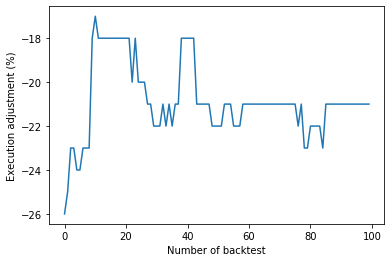

In [51]:
# The best execution of 100 different periods
BestExec = pd.Series(BestExec)
plt.xlabel('Number of backtest')
plt.ylabel('Execution adjustment (%)')
BestExec.plot();

In [52]:
Best_i = BestExec.iloc[-1]
Best_i

-21

In [53]:
cols = []

# List for the results for evaluation
PortfolioReturn = []
StandardDeviation = []
Max = []
Min = []
SharpRatio = []
InformationRatio = []

for i in list(range(0, 51, 1)):
    Return_i = []
    Exec_list_i = list(df_buyer_strategy1_ex["Exec_" + str(i) + "%"]) 
    for e in Exec_list_i:
        Return_i.append(e)

    Return_i = pd.Series(Return_i)
    PortfolioReturn.append(Return_i.mean().round(2))
    StandardDeviation.append(Return_i.std().round(2))
    Max.append(Return_i.max().round(2))
    Min.append(Return_i.min().round(2))
    SharpRatio.append((Return_i.mean()/Return_i.std()).round(2))
    InformationRatio.append(round((Return_i - Benchmark_buyer).mean() / (Return_i - Benchmark_buyer).std(), 3))

    # Make columns names
    cols.append("Exec+" + str(i) + "%")

# Make dataframe for evaluation and  switch columns and row.
df_buyer_strategy1_ex_eval = pd.DataFrame()

# Add columns for evaluation metrics
df_buyer_strategy1_ex_eval["PortfolioReturn"] = pd.Series(PortfolioReturn)
df_buyer_strategy1_ex_eval["StandardDeviation"] = pd.Series(StandardDeviation)
df_buyer_strategy1_ex_eval["Max"] = pd.Series(Max)
df_buyer_strategy1_ex_eval["Min"] = pd.Series(Min)
df_buyer_strategy1_ex_eval["SharpRatio"] = pd.Series(SharpRatio)
df_buyer_strategy1_ex_eval["InformationRatio"] = pd.Series(InformationRatio)

df_buyer_strategy1_ex_eval.index = cols

In [54]:
# Pick up the portfolios on the global minimum variance portfolio
std_min = df_buyer_strategy1_ex_eval[df_buyer_strategy1_ex_eval["StandardDeviation"] == df_buyer_strategy1_ex_eval["StandardDeviation"].min()]
GMVP = std_min[std_min["PortfolioReturn"] == std_min["PortfolioReturn"].max()]
GMVP

,PortfolioReturn,StandardDeviation,Max,Min,SharpRatio,InformationRatio
Exec+6%,-8.35,4.46,-0.01,-150.0,-1.87,0.047


In [55]:
# The best portfolio
Best = df_buyer_strategy1_ex_eval[df_buyer_strategy1_ex_eval["InformationRatio"] == df_buyer_strategy1_ex_eval["InformationRatio"].max()]
Best = Best[Best["StandardDeviation"] == Best["StandardDeviation"].min()]
Best

,PortfolioReturn,StandardDeviation,Max,Min,SharpRatio,InformationRatio
Exec+21%,-7.85,4.71,-0.01,-150.0,-1.67,0.175


[Global Minimum Variance Portfolio]
Position: DA 76.35%
Expected return: -8.35
Standard deviation: 4.46
Sharp ratio: -1.87
Information ratio: 0.047
[Best Execution Portfolio]
Position: DA 94.25%
Expected return: -7.85
Standard deviation: 4.71
Sharp ratio: -1.67
Information ratio: 0.17


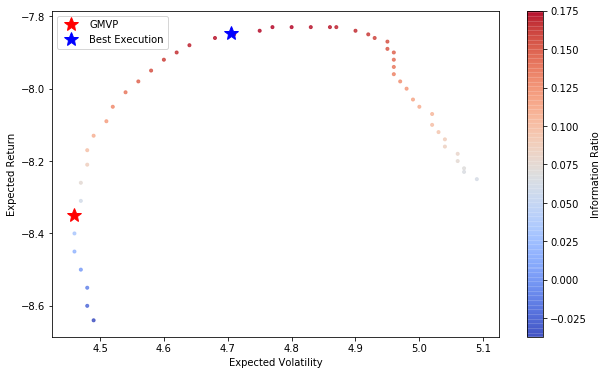

In [56]:
plt.figure(figsize=(10,6))

# Scatter plot all the possible portfolios
plt.scatter(df_buyer_strategy1_ex_eval["StandardDeviation"], df_buyer_strategy1_ex_eval["PortfolioReturn"], c=df_buyer_strategy1_ex_eval["InformationRatio"], marker='.', alpha=0.8, cmap='coolwarm')

# Global minimum variance portfolio
plt.plot(GMVP["StandardDeviation"], GMVP["PortfolioReturn"], 'r*', markersize=15.0, label="GMVP")
print("[Global Minimum Variance Portfolio]")
i = 6
DA_position_i = df_buyer_strategy1_ex["Position_" + str(i) + "%"].value_counts()[0] 
Intra_position_i = df_buyer_strategy1_ex["Position_" + str(i) + "%"].value_counts()[1]
print("Position: DA {}".format(round(DA_position_i / (DA_position_i+Intra_position_i)*100, 2)) + "%")
print("Expected return: {}".format(GMVP["PortfolioReturn"][0]))
print("Standard deviation: {}".format(GMVP["StandardDeviation"][0]))
print("Sharp ratio: {}".format(GMVP["SharpRatio"][0]))
print("Information ratio: {}".format(GMVP["InformationRatio"][0]))

print("[Best Execution Portfolio]")
i = -Best_i
DA_position_i = df_buyer_strategy1_ex["Position_" + str(i) + "%"].value_counts()[0] 
Intra_position_i = df_buyer_strategy1_ex["Position_" + str(i) + "%"].value_counts()[1]
plt.plot(df_buyer_strategy1_ex["Exec_" + str(i) + "%"].std(), df_buyer_strategy1_ex["Exec_" + str(i) + "%"].mean(), "b*", markersize=15.0, label="Best Execution")
print("Position: DA {}".format(round(DA_position_i / (DA_position_i+Intra_position_i)*100, 2)) + "%")
print("Expected return: {}".format(df_buyer_strategy1_ex["Exec_" + str(i) + "%"].mean().round(2)))
print("Standard deviation: {}".format(df_buyer_strategy1_ex["Exec_" + str(i) + "%"].std().round(2)))
print("Sharp ratio: {}".format(round(df_buyer_strategy1_ex["Exec_" + str(i) + "%"].mean() / df_buyer_strategy1_ex["Exec_" + str(i) + "%"].std(),2)))
print("Information ratio: {}".format(round((df_buyer_strategy1_ex["Exec_" + str(i) + "%"] - Benchmark_buyer).mean() / (df_buyer_strategy1_ex["Exec_" + str(i) + "%"] - Benchmark_buyer).std(),2)))

plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Information Ratio')
plt.legend(loc="upper left");

## Strategy 2 (Trading with prediction after DA)

### Required dataset

In [57]:
# Need predicted price after DA market and spot price
df_buyer_strategy2 = df_prediction_afterDA.copy()

# Make lists for price information
Spot_list = list(df_buyer_strategy2["Spot"])
Low_list = list(df_buyer_strategy2["Low"])
Close_list = list(df_buyer_strategy2["Close"])
Pred_list_i = list(df_buyer_strategy2["Close_pred"])
# Judge_success = []
                   
# list for executed orders
Executed_i = []
# list for checking the execution results
Judge_i = []    
                   
# Calculate executed price
for l, c, p in zip(Low_list, Close_list, Pred_list_i):     
    # Trade on Intra markets
    if p >= l:
        Executed_i.append(p)
        Judge_i.append("True")
    else:
        Executed_i.append(c)
        Judge_i.append("False")                 

df_buyer_strategy2["ExecutedOrder"] = pd.Series(Executed_i)
df_buyer_strategy2["Judge"] = pd.Series(Judge_i)

In [58]:
df_buyer_strategy2.head()

,DateTime,Spot,High,Low,Close,Close_pred,ExecutedOrder,Judge
0,2017-08-10 00:00:00,7.98,12.98,5.94,9.4,7.89,7.89,True
1,2017-08-10 00:30:00,7.67,12.67,5.63,9.4,7.72,7.72,True
2,2017-08-10 01:00:00,6.86,11.86,5.58,9.4,7.26,7.26,True
3,2017-08-10 01:30:00,6.58,11.58,4.91,9.4,6.79,6.79,True
4,2017-08-10 02:00:00,6.62,11.62,4.88,9.4,6.82,6.82,True


### Evaluation

In [59]:
portfolio_weights= [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

cols = []

PortfolioReturn = []
StandardDeviation = []
Max = []
Min = []
SharpRatio = []
InformationRatio = []

Spot_list = list(df_buyer_strategy2["Spot"])
Exec_list = list(df_buyer_strategy2["ExecutedOrder"])

for weight in portfolio_weights:
    Return = []
    for spot, intra in zip(Spot_list, Exec_list):
        # DA market 100%
        if weight == 1.0:
            Return.append(-spot*weight)
        # Trade both on DA and Intra day
        else:
            Return.append(-spot*weight + -intra*(1-weight))
    # Set colmun name
    cols.append("DA" + str(weight*100) + "%")

    # Results
    Return = pd.Series(Return)
    PortfolioReturn.append(Return.mean().round(2))
    StandardDeviation.append(Return.std().round(2))
    Max.append(Return.max().round(2))
    Min.append(Return.min().round(2))
    SharpRatio.append((Return.mean()/Return.std()).round(2))
    InformationRatio.append(round((Return - Benchmark_buyer).mean() / (Return - Benchmark_buyer).std(), 3))

# Transpose columns and rows
df_buyer_strategy2_eval = pd.DataFrame()
df_buyer_strategy2_eval = df_buyer_strategy2_eval.T

# Add columns for evaluation metrics
df_buyer_strategy2_eval["PortfolioReturn"] = pd.Series(PortfolioReturn)
df_buyer_strategy2_eval["StandardDeviation"] = pd.Series(StandardDeviation)
df_buyer_strategy2_eval["Max"] = pd.Series(Max)
df_buyer_strategy2_eval["Min"] = pd.Series(Min)
df_buyer_strategy2_eval["SharpRatio"] = pd.Series(SharpRatio)
df_buyer_strategy2_eval["InformationRatio"] = pd.Series(InformationRatio)

df_buyer_strategy2_eval.index = cols

In [60]:
df_buyer_strategy2_eval

,PortfolioReturn,StandardDeviation,Max,Min,SharpRatio,InformationRatio
DA0%,-8.40,4.15,-0.16,-150.00,-2.03,0.083
DA10.0%,-8.42,4.16,-0.15,-139.70,-2.02,0.083
DA20.0%,-8.43,4.18,-0.13,-129.41,-2.02,0.083
DA30.0%,-8.44,4.20,-0.12,-119.11,-2.01,0.083
DA40.0%,-8.46,4.23,-0.10,-108.82,-2.00,0.083
DA50.0%,-8.47,4.26,-0.08,-98.52,-1.99,0.083
DA60.0%,-8.48,4.30,-0.07,-88.22,-1.97,0.083
DA70.0%,-8.49,4.35,-0.06,-78.95,-1.95,0.083
DA80.0%,-8.51,4.40,-0.04,-79.30,-1.93,0.083
DA90.0%,-8.52,4.45,-0.02,-79.65,-1.91,0.083


In [61]:
# Pick up the portfolios on the global minimum variance portfolio
std_min = df_buyer_strategy2_eval[df_buyer_strategy2_eval["StandardDeviation"] == df_buyer_strategy2_eval["StandardDeviation"].min()]
GMVP = std_min[std_min["PortfolioReturn"] == std_min["PortfolioReturn"].min()]
GMVP

,PortfolioReturn,StandardDeviation,Max,Min,SharpRatio,InformationRatio
DA0%,-8.4,4.15,-0.16,-150.0,-2.03,0.083


In [62]:
# The Best Execusion
Best = df_buyer_strategy2_eval[df_buyer_strategy2_eval["InformationRatio"] == df_buyer_strategy2_eval["InformationRatio"].max()]
Best = Best[Best["StandardDeviation"] == Best["StandardDeviation"].min()]
Best

,PortfolioReturn,StandardDeviation,Max,Min,SharpRatio,InformationRatio
DA0%,-8.4,4.15,-0.16,-150.0,-2.03,0.083


[Global Minimum Variance Portfolio]
Expected return: -8.4
Standard deviation: 4.15
Sharp ratio: -2.03
Information ratio: 0.083
[Best Execution Portfolio]
Expected return: -8.4
Standard deviation: 4.15
Sharp ratio: -2.03
Information ratio: 0.083


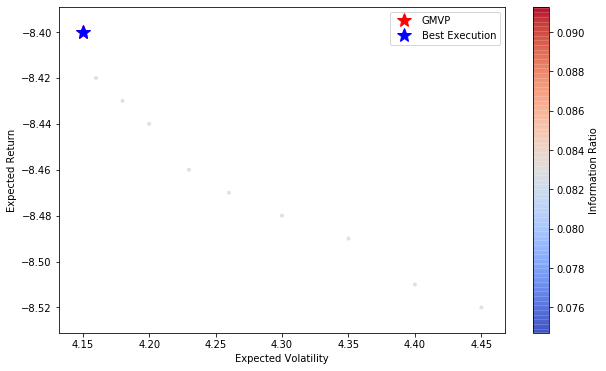

In [63]:
plt.figure(figsize=(10,6))

# Scatter plot all the possible portfolios
plt.scatter(df_buyer_strategy2_eval["StandardDeviation"], df_buyer_strategy2_eval["PortfolioReturn"], c=df_buyer_strategy2_eval["InformationRatio"], marker='.', alpha=0.8, cmap='coolwarm')

# Global minimum variance portfolio
plt.plot(GMVP["StandardDeviation"], GMVP["PortfolioReturn"], 'r*', markersize=15.0, label="GMVP")
print("[Global Minimum Variance Portfolio]")
print("Expected return: {}".format(GMVP["PortfolioReturn"][0]))
print("Standard deviation: {}".format(GMVP["StandardDeviation"][0]))
print("Sharp ratio: {}".format(GMVP["SharpRatio"][0]))
print("Information ratio: {}".format(GMVP["InformationRatio"][0]))

# Best executed portfolio
plt.plot(Best["StandardDeviation"], Best["PortfolioReturn"], "b*", markersize=15.0, label="Best Execution")
print("[Best Execution Portfolio]")
print("Expected return: {}".format(Best["PortfolioReturn"][0]))
print("Standard deviation: {}".format(Best["StandardDeviation"][0]))
print("Sharp ratio: {}".format(Best["SharpRatio"][0]))
print("Information ratio: {}".format(Best["InformationRatio"][0]))

plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Information Ratio')
plt.legend(loc="upper right");

## Strategy 2 with execution strategy

### Required dataset

In [64]:
# Need predicted price after DA market and spot price
df_buyer_strategy2_ex = df_prediction_beforeDA.copy()

# Make lists for price information
Spot_list = list(df_buyer_strategy2_ex["Spot"])
Low_list = list(df_buyer_strategy2_ex["Low"])
Close_list = list(df_buyer_strategy2_ex["Close"])
# Judge_success = []

# Order and execution with execusion range
for i in list(range(0, 51, 1)):
    # list for executed orders
    Executed_i = []
    # list for checking the execution results
    Judge_i = []    
    Position_i = []
    # Derive the predicted price with the range
    Pred_list_i = list((df_buyer_strategy2_ex["Close_pred"]* (1 - i/100)).round(2))
    for l, c, p in zip(Low_list, Close_list, Pred_list_i):     
        # Trade on Intra markets
        if p >= l:
            Executed_i.append(p)
            Judge_i.append("True")
            Position_i.append("DA")
        else:
            Executed_i.append(c)
            Judge_i.append("False") 
            Position_i.append("Intra")
                
    df_buyer_strategy2_ex["Exec_" + str(i) + "%"] = pd.Series(Executed_i)
    df_buyer_strategy2_ex["Judge_" + str(i) + "%"] = pd.Series(Judge_i)
    df_buyer_strategy2_ex["Position_" + str(i) + "%"] = pd.Series(Position_i)
    
df_buyer_strategy2_ex.head()

,Date,HH,Open,High,Low,Close,Spot,Spot_1daylag,DateTime,Close_pred,Exec_0%,Judge_0%,Position_0%,Exec_1%,Judge_1%,Position_1%,Exec_2%,Judge_2%,Position_2%,Exec_3%,Judge_3%,Position_3%,Exec_4%,Judge_4%,Position_4%,Exec_5%,Judge_5%,Position_5%,Exec_6%,Judge_6%,Position_6%,Exec_7%,Judge_7%,Position_7%,Exec_8%,Judge_8%,Position_8%,Exec_9%,Judge_9%,Position_9%,Exec_10%,Judge_10%,Position_10%,Exec_11%,Judge_11%,Position_11%,Exec_12%,Judge_12%,Position_12%,Exec_13%,Judge_13%,Position_13%,Exec_14%,Judge_14%,Position_14%,Exec_15%,Judge_15%,Position_15%,Exec_16%,Judge_16%,Position_16%,Exec_17%,Judge_17%,Position_17%,Exec_18%,Judge_18%,Position_18%,Exec_19%,Judge_19%,Position_19%,Exec_20%,Judge_20%,Position_20%,Exec_21%,Judge_21%,Position_21%,Exec_22%,Judge_22%,Position_22%,Exec_23%,Judge_23%,Position_23%,Exec_24%,Judge_24%,Position_24%,Exec_25%,Judge_25%,Position_25%,Exec_26%,Judge_26%,Position_26%,Exec_27%,Judge_27%,Position_27%,Exec_28%,Judge_28%,Position_28%,Exec_29%,Judge_29%,Position_29%,Exec_30%,Judge_30%,Position_30%,Exec_31%,Judge_31%,Position_31%,Exec_32%,Judge_32%,Position_32%,Exec_33%,Judge_33%,Position_33%,Exec_34%,Judge_34%,Position_34%,Exec_35%,Judge_35%,Position_35%,Exec_36%,Judge_36%,Position_36%,Exec_37%,Judge_37%,Position_37%,Exec_38%,Judge_38%,Position_38%,Exec_39%,Judge_39%,Position_39%,Exec_40%,Judge_40%,Position_40%,Exec_41%,Judge_41%,Position_41%,Exec_42%,Judge_42%,Position_42%,Exec_43%,Judge_43%,Position_43%,Exec_44%,Judge_44%,Position_44%,Exec_45%,Judge_45%,Position_45%,Exec_46%,Judge_46%,Position_46%,Exec_47%,Judge_47%,Position_47%,Exec_48%,Judge_48%,Position_48%,Exec_49%,Judge_49%,Position_49%,Exec_50%,Judge_50%,Position_50%
0,2017-08-10,1,10.70,12.98,5.94,9.4,8.19,8.10,2017-08-10 00:00:00,7.83,7.83,True,DA,7.75,True,DA,7.67,True,DA,7.60,True,DA,7.52,True,DA,7.44,True,DA,7.36,True,DA,7.28,True,DA,7.20,True,DA,7.13,True,DA,7.05,True,DA,6.97,True,DA,6.89,True,DA,6.81,True,DA,6.73,True,DA,6.66,True,DA,6.58,True,DA,6.50,True,DA,6.42,True,DA,6.34,True,DA,6.26,True,DA,6.19,True,DA,6.11,True,DA,6.03,True,DA,5.95,True,DA,9.40,False,Intra,9.40,False,Intra,9.40,False,Intra,9.40,False,Intra,9.40,False,Intra,9.40,False,Intra,9.40,False,Intra,9.40,False,Intra,9.40,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra
1,2017-08-10,2,6.89,12.67,5.63,9.4,8.04,8.00,2017-08-10 00:30:00,7.58,7.58,True,DA,7.50,True,DA,7.43,True,DA,7.35,True,DA,7.28,True,DA,7.20,True,DA,7.13,True,DA,7.05,True,DA,6.97,True,DA,6.90,True,DA,6.82,True,DA,6.75,True,DA,6.67,True,DA,6.59,True,DA,6.52,True,DA,6.44,True,DA,6.37,True,DA,6.29,True,DA,6.22,True,DA,6.14,True,DA,6.06,True,DA,5.99,True,DA,5.91,True,DA,5.84,True,DA,5.76,True,DA,5.68,True,DA,9.40,False,Intra,9.40,False,Intra,9.40,False,Intra,9.40,False,Intra,9.40,False,Intra,9.40,False,Intra,9.40,False,Intra,9.40,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra
2,2017-08-10,3,6.42,11.86,5.58,9.4,7.93,8.05,2017-08-10 01:00:00,7.55,7.55,True,DA,7.47,True,DA,7.40,True,DA,7.32,True,DA,7.25,True,DA,7.17,True,DA,7.10,True,DA,7.02,True,DA,6.95,True,DA,6.87,True,DA,6.80,True,DA,6.72,True,DA,6.64,True,DA,6.57,True,DA,6.49,True,DA,6.42,True,DA,6.34,True,DA,6.27,True,DA,6.19,True,DA,6.12,True,DA,6.04,True,DA,5.96,True,DA,5.89,True,DA,5.81,True,DA,5.74,True,DA,5.66,True,DA,5.59,True,DA,9.40,False,Intra,9.40,False,Intra,9.40,False,Intra,9.40,False,Intra,9.40,False,Intra,9.40,False,Intra,9.40,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,Intra,9.4,False,

### Evaluation

- Look for the best execution

In [65]:
n_splits=100

train_size = df_buyer_strategy2_ex.index[-1]
train_index_list = list(np.linspace(train_size/n_splits, train_size, n_splits, endpoint = True, dtype='int'))
train_index_list

# # Confirming the split logic
# for train_index in train_index_list:
#     # Divide the train/valid set  into 10 folds and pick up it.
#     X_train = df_buyer_strategy2_ex.iloc[:train_index]
#     print("TRAIN:", train_index)

[595,
 1190,
 1785,
 2380,
 2975,
 3571,
 4166,
 4761,
 5356,
 5951,
 6547,
 7142,
 7737,
 8332,
 8927,
 9523,
 10118,
 10713,
 11308,
 11903,
 12498,
 13094,
 13689,
 14284,
 14879,
 15474,
 16070,
 16665,
 17260,
 17855,
 18450,
 19046,
 19641,
 20236,
 20831,
 21426,
 22022,
 22617,
 23212,
 23807,
 24402,
 24997,
 25593,
 26188,
 26783,
 27378,
 27973,
 28569,
 29164,
 29759,
 30354,
 30949,
 31545,
 32140,
 32735,
 33330,
 33925,
 34521,
 35116,
 35711,
 36306,
 36901,
 37496,
 38092,
 38687,
 39282,
 39877,
 40472,
 41068,
 41663,
 42258,
 42853,
 43448,
 44044,
 44639,
 45234,
 45829,
 46424,
 47020,
 47615,
 48210,
 48805,
 49400,
 49995,
 50591,
 51186,
 51781,
 52376,
 52971,
 53567,
 54162,
 54757,
 55352,
 55947,
 56543,
 57138,
 57733,
 58328,
 58923,
 59519]

In [ ]:
BestExec = []

for train_index in train_index_list:
    X_train = df_buyer_strategy2_ex[:train_index]

    Spot_list = list(X_train["Spot"])

    portfolio_weights= [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    execution_buffers = list(range(0, 51, 1))

    cols = []

    PortfolioReturn = []
    StandardDeviation = []
    Max = []
    Min = []
    SharpRatio = []
    InformationRatio = []
    
    for i in execution_buffers:
        Exec_list = list(X_train["Exec_" + str(i) + "%"])
        for weight in portfolio_weights:
            Return = []
            for spot, intra in zip(Spot_list, Exec_list):
                # DA market 100%
                if weight == 1.0:
                    Return.append(-spot*weight)
                # Trade both on DA and Intra day
                else:
                    Return.append(-spot*weight + -intra*(1-weight))
            # Set colmun name for execution buffer
            if weight == 1.0:
                cols.append(str(0))
            else:
                cols.append(str(i))

            # Results
            Return = pd.Series(Return)
            PortfolioReturn.append(Return.mean().round(2))
            StandardDeviation.append(Return.std().round(2))
            Max.append(Return.max().round(2))
            Min.append(Return.min().round(2))
            SharpRatio.append((Return.mean()/Return.std()).round(2))
            InformationRatio.append(round((Return - Benchmark_buyer).mean() / (Return - Benchmark_buyer).std(), 3))

    #df_portfolio_benchの列を設定し、行列を入替えて調整する
    df_buyer_strategy2_ex_eval = pd.DataFrame()
    df_buyer_strategy2_ex_eval = df_buyer_strategy2_ex_eval.T

    #各算出結果をdf_portfolio_benchの列へ追加する
    df_buyer_strategy2_ex_eval["PortfolioReturn"] = pd.Series(PortfolioReturn)
    df_buyer_strategy2_ex_eval["StandardDeviation"] = pd.Series(StandardDeviation)
    df_buyer_strategy2_ex_eval["Max"] = pd.Series(Max)
    df_buyer_strategy2_ex_eval["Min"] = pd.Series(Min)
    df_buyer_strategy2_ex_eval["SharpRatio"] = pd.Series(SharpRatio)
    df_buyer_strategy2_ex_eval["InformationRatio"] = pd.Series(InformationRatio)
    
    df_buyer_strategy2_ex_eval.index = cols
    df_buyer_strategy2_ex_eval =  df_buyer_strategy2_ex_eval.reset_index()
    df_buyer_strategy2_ex_eval = df_buyer_strategy2_ex_eval.rename(columns={"index": "ExecBuffer(%)"})
    df_buyer_strategy2_ex_eval["ExecBuffer(%)"] = df_buyer_strategy2_ex_eval["ExecBuffer(%)"].astype(int)

    Exec = df_buyer_strategy2_ex_eval[df_buyer_strategy2_ex_eval["InformationRatio"] == df_buyer_strategy2_ex_eval["InformationRatio"].max()]
    Exec = -Exec["ExecBuffer(%)"][Exec["StandardDeviation"] == Exec["StandardDeviation"].min()].iloc[0]
    BestExec.append(Exec)

In [ ]:
# BestExec = pd.Series(BestExec)
BestExec = pd.Series(BestExec).astype(int)
plt.xlabel('Number of backtest')
plt.ylabel('Execution adjustment (%)')
BestExec.plot();

In [ ]:
Best_i = BestExec.iloc[-1]
Best_i

- Plot all the possible portfolios

In [ ]:
Spot_list = list(df_buyer_strategy2_ex["Spot"])

portfolio_weights= [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
execution_buffers = list(range(0, 51, 1))

cols = []

PortfolioReturn = []
StandardDeviation = []
Max = []
Min = []
SharpRatio = []
InformationRatio = []

for i in execution_buffers:
    Exec_list = list(df_buyer_strategy2_ex["Exec_" + str(i) + "%"])
    for weight in portfolio_weights:
        Return = []
        for spot, intra in zip(Spot_list, Exec_list):
            # DA market 100%
            if weight == 1.0:
                Return.append(-spot*weight)
            # Trade both on DA and Intra day
            else:
                Return.append(-spot*weight + -intra*(1-weight))
        # Set colmun name for execution buffer
        if weight == 1.0:
            cols.append("DA100%")
        else:
            cols.append("DA" + str(weight*100) + "%_Exec+" + str(i) + "%")

        # Results
        Return = pd.Series(Return)
        PortfolioReturn.append(Return.mean().round(2))
        StandardDeviation.append(Return.std().round(2))
        Max.append(Return.max().round(2))
        Min.append(Return.min().round(2))
        SharpRatio.append((Return.mean()/Return.std()).round(2))
        InformationRatio.append(((Return - Benchmark_buyer).mean()/(Return - Benchmark_buyer).std()).round(3))

#df_portfolio_benchの列を設定し、行列を入替えて調整する
df_buyer_strategy2_ex_eval = pd.DataFrame()
df_buyer_strategy2_ex_eval = df_buyer_strategy2_ex_eval.T

#各算出結果をdf_portfolio_benchの列へ追加する
df_buyer_strategy2_ex_eval["PortfolioReturn"] = pd.Series(PortfolioReturn)
df_buyer_strategy2_ex_eval["StandardDeviation"] = pd.Series(StandardDeviation)
df_buyer_strategy2_ex_eval["Max"] = pd.Series(Max)
df_buyer_strategy2_ex_eval["Min"] = pd.Series(Min)
df_buyer_strategy2_ex_eval["SharpRatio"] = pd.Series(SharpRatio)
df_buyer_strategy2_ex_eval["InformationRatio"] = pd.Series(InformationRatio)

df_buyer_strategy2_ex_eval.index = cols

In [ ]:
df_buyer_strategy2_ex_eval

In [ ]:
# Pick up the portfolios on the global minimum variance portfolio
std_min = df_buyer_strategy2_ex_eval[df_buyer_strategy2_ex_eval["StandardDeviation"] == df_buyer_strategy2_ex_eval["StandardDeviation"].min()]
GMVP = std_min[std_min["PortfolioReturn"] == std_min["PortfolioReturn"].min()]
GMVP

In [ ]:
Best = df_buyer_strategy2_ex_eval[df_buyer_strategy2_ex_eval["InformationRatio"] == df_buyer_strategy2_ex_eval["InformationRatio"].max()]
Best = Best[Best["StandardDeviation"] == Best["StandardDeviation"].min()]
Best

In [ ]:
plt.figure(figsize=(10,6))

# Scatter plot all the possible portfolios
plt.scatter(df_buyer_strategy2_ex_eval["StandardDeviation"], df_buyer_strategy2_ex_eval["PortfolioReturn"], c=df_buyer_strategy2_ex_eval["InformationRatio"], marker='.', alpha=0.8, cmap='coolwarm')


# Global minimum variance portfolio
plt.plot(GMVP["StandardDeviation"], GMVP["PortfolioReturn"], 'r*', markersize=15.0, label="GMVP")
print("[Global Minimum Variance Portfolio: " + str(GMVP.index[0]) + "]")

print("Expected return: {}".format(GMVP["PortfolioReturn"][0]))
print("Standard deviation: {}".format(GMVP["StandardDeviation"][0]))
print("Information Ratio: {}".format(GMVP["InformationRatio"][0]))

# The Best Execusion
DA_weight = 0
i = -Best_i
Best_Portfolio = (DA_weight * -df_buyer_strategy2_ex["Spot"]) + ((1 - DA_weight) * -df_buyer_strategy2_ex["Exec_" + str(i) + "%"])
plt.plot(Best_Portfolio.std(), Best_Portfolio.mean(), "b*", markersize=15.0, label="Best Execution")
print("[Best Execution Portfolio: " + str(DA_weight) + "%_Exec+" + str(i) + "%]")
print("Expected return: {}".format(Best_Portfolio.mean().round(2)))
print("Standard deviation: {}".format(Best_Portfolio.std().round(2)))
print("Sharp ratio: {}".format(round(Best_Portfolio.mean() / Best_Portfolio.std(), 2)))
print("Information ratio: {}".format(round((Best_Portfolio - Benchmark_buyer).mean() / (Best_Portfolio - Benchmark_buyer).std(), 3)))

plt.title('Strategic portfolios with excution adjustment for buyers')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Information Ratio')
plt.legend(loc="upper left");

In [ ]:
Best_Portfolio

# For Trader (Virtual bidding strategy)

[Purpose]
- To confirm the market efficiency of the JEPX 
- To examine virtual bidding as a potential solution for improving liquidity of the DA and the intraday market on the JEPX

[Basic logic for virtual bidding] <p>
1) Make long or short positions on the DA market <p>
2) Settle all the positions by counter trading on the intraday market on the day <p>
    - Spot > Close: Entry with sell-in on the DA  and buy-out on the intraday <p>
    - Spot < Close: Entry with buy-in on the DA and sell-out on the intraday

## Trading without execution strategy

In [ ]:
df_trader = df_prediction_beforeDA.copy()
df_trader["Date"] = pd.to_datetime(df_trader["Date"])
df_trader["DateTime"] = pd.to_datetime(df_trader["DateTime"])
df_trader.head()

### Evaluation

In [ ]:
# For execution
LaggedSpot_list = list(df_trader["Spot_1daylag"])
Pred_list = list(df_trader["Close_pred"])
Close_list = list(df_trader["Close"])
High_list = list(df_trader["High"])
Low_list = list(df_trader["Low"])

# For evaluation
Spot_list = list(df_trader["Spot"])

# Lists for results
cols = []
Return = [] 
PortfolioReturn = []
StandardDeviation = []
Max = []
Min = []
SharpRatio = []

# Main logic
for spot, lag_spot, pred, high, low, close in zip(Spot_list,LaggedSpot_list, Pred_list, High_list, Low_list, Close_list):
    #　Buy-in, Sell-out　※ Decision based on lag_spot and pred
    if lag_spot < pred:
        #Return ※ Evaluation based on spot and pred/close
        # Succeed
        if pred < high:
            Return.append(round(pred - spot, 4))
        # Fail
        else:
            Return.append(round(close - spot, 4))
            
    # Sell-in, Buy-out ※ Decision based on lag_spot and pred
    elif lag_spot > pred:
        #Return ※ Evaluation based on spot and pred/close
        # Succeed
        if pred > low:
            Return.append(round(spot - pred, 4))
        # Fail
        else:
            Return.append(round(spot - close, 4))
    # lag_spot is the same as pred --> No trade
    else:
        Return.append(0)

df_trader_eval = pd.DataFrame()
df_trader_eval["DateTime"] = df_trader["DateTime"]
df_trader_eval["HH"] = df_trader["HH"]
df_trader_eval["Date"] = df_trader["Date"]
df_trader_eval["Return"] = pd.Series(Return)

In [ ]:
df_trader_eval.head()

In [ ]:
# Make a pivot table for results
df_trader_portfolio_table = pd.DataFrame(df_trader_eval.pivot(index='Date', columns='HH', values='Return'))
df_trader_portfolio_table["Expected_Return"] = df_trader_portfolio_table.loc[: , 0:48].mean(axis=1).round(2)
df_trader_portfolio_table["SharpRatio"] = (df_trader_portfolio_table.loc[: , 1:48].mean(axis=1)/df_trader_portfolio_table.loc[: , 1:48].std(axis=1)).round(2)

# Make a new table for performance graph
risk = pd.DataFrame()
risk["Expected_Return"] = df_trader_portfolio_table.loc[: , 1:48].mean(axis=1).round(2)
risk["equity"] = risk['Expected_Return'].cumsum()
risk["cummax"] = risk["equity"].cummax()
risk["drawdown"] = -(risk["cummax"] -risk["equity"])

risk.head()

In [ ]:
# Set max_drawdown
max_drawdown = risk["drawdown"].min()

# Set timestamp of max_drawdown
t_max = pd.to_datetime(risk["drawdown"].idxmin())

# Plot the performance
fig, ax = plt.subplots(1, figsize=(15,8))
# plt.title('Cumulative return through trading based on the difference of price on DA and Intraday')

risk["equity"].plot(figsize=(10, 6), label="Cum_Return")

plt.text(t_max, 0, 'Max_D', rotation=0, color="r")

print("Expected_Return: " + str(risk["Expected_Return"].mean().round(2)))
print("StandardDeviation: " + str(risk["Expected_Return"].std().round(2)))
print("SharpRatio: " + str(round(risk["Expected_Return"].mean() /  risk["Expected_Return"].std(),2)))
print("Cum_Return: " + str(risk["equity"][-1:][0].round(2)))
print("Drawdown: " + str(risk["drawdown"].min().round(2)))

ax.set(xlabel="Date", ylabel="Cumulative return(Yen/kWh)")
plt.axvline(t_max, c="r", alpha=0.5)
plt.grid()
plt.legend();

In [ ]:
# Distribution of expected return
plt.figure(figsize=(5, 3))

plt.hist(risk['Expected_Return'], bins=100);

In [ ]:
# Calculate VaR
import scipy.stats as scs

equity = 10000000

percs = np.array([1., 5.0, 10.0])
risk["returns"] = np.log(risk["equity"] / risk["equity"].shift(1))
VaR = scs.scoreatpercentile(equity * risk["returns"], percs)
def print_var():
    print('%16s %16s' % ('Confidence Level', 'Value-at-Risk'))
    print(43 * '-')
    for pair in zip(percs, VaR):
        print('%16.0f %16.0f' % (100 - pair[0], -pair[1]))
        
print_var()

In [ ]:
# Plot each 48 item separately
fig, ax = plt.subplots(1, figsize=(15,8))
# plt.title('Cumulative return through trading based on the difference of price on DA and Intraday')

# Lists for results
Equity = []
ExpectedReturn = []
Max = []
Min = []
StandardDeviation = []
SharpRatio= []
CumMax = []
MaxDrawdown = []

for HH in list(range(1, 49, 1)):
    #　makng a pivot table
    df_trader_portfolio_table = pd.DataFrame(df_trader_eval.pivot(index='Date', columns='HH', values='Return'))
    
    # For plot and for calculating drawdown
    equity = df_trader_portfolio_table[HH].cumsum().round(2)
    # Plot the performance of each HH spot
    equity.plot(label="HH" + str(HH))
    
    # Keep in a list for calculating drawdown
    Equity.append(equity)
    cummax = equity.cummax()
    drawdown = -(cummax - equity)

    # Calculation for each evaluation on each HH slot
    HH_Return = df_trader_portfolio_table[HH].mean().round(2)
    HH_Std = df_trader_portfolio_table[HH].std().round(2)
    ExpectedReturn.append(HH_Return)
    StandardDeviation.append(HH_Std)
    Max.append(df_trader_portfolio_table[HH].max().round(2))
    Min.append(df_trader_portfolio_table[HH].min().round(2))
    SharpRatio.append((HH_Return / HH_Std).round(2))
    CumMax.append(cummax.max().round(2))
    MaxDrawdown.append(drawdown.min().round(2))

ax.set(xlabel="Date", ylabel="Cumulative return(Yen/kWh)")
plt.grid()
plt.legend(loc="upper left", ncol=6);

In [ ]:
# Make a table for evaluation metrics for all items
df_trader_HH_Eval = pd.DataFrame()
df_trader_HH_Eval["HH"] =  pd.Series(list(range(1,49,1)))
df_trader_HH_Eval["ExpectedReturn"]  = pd.Series(ExpectedReturn)
df_trader_HH_Eval["Max"]  = pd.Series(Max)
df_trader_HH_Eval["Min"]  = pd.Series(Min)
df_trader_HH_Eval["StandardDeviation"]  = pd.Series(StandardDeviation)
df_trader_HH_Eval["SharpRatio"]  = pd.Series(SharpRatio)
df_trader_HH_Eval["CumMax"] = pd.Series(CumMax)
df_trader_HH_Eval["MaxDrawdown"]  = pd.Series(MaxDrawdown)

In [ ]:
df_trader_HH_Eval[df_trader_HH_Eval["CumMax"] == df_trader_HH_Eval["CumMax"].max()]

HH46 --> 22:30

In [ ]:
df_trader_HH_Eval[df_trader_HH_Eval["SharpRatio"] == df_trader_HH_Eval["SharpRatio"].max()]

HH3 --> 1:00

In [ ]:
df_trader_HH_Eval[df_trader_HH_Eval["CumMax"] == df_trader_HH_Eval["CumMax"].min()]

HH18 --> 8:30

In [ ]:
df_trader_HH_Eval[df_trader_HH_Eval["MaxDrawdown"] == df_trader_HH_Eval["MaxDrawdown"].max()]

HH6 --> 2:30

In [ ]:
# Distribution of expected return
fig, ax = plt.subplots(1, figsize=(5,3))
plt.hist(df_trader_portfolio_table[6], bins=100)
plt.ylim(0, 500)
ax.set(xlabel="ExpectedReturn", ylabel="Frequency")
plt.grid();

In [ ]:
df_trader_HH_Eval[df_trader_HH_Eval["MaxDrawdown"] == df_trader_HH_Eval["MaxDrawdown"].min()]

HH34 --> 16:30

In [ ]:
# Distribution of expected return
fig, ax = plt.subplots(1, figsize=(5,3))
df_trader_portfolio_table[34].hist(bins=100)
plt.ylim(0, 500)
ax.set(xlabel="ExpectedReturn", ylabel="Frequency");

## Trading with execution strategy

### Required dataset

In [ ]:
Spot_list = list(df_trader["Spot"])
LaggedSpot_list = list(df_trader["Spot_1daylag"])
Close_list = list(df_trader["Close"])
High_list = list(df_trader["High"])
Low_list = list(df_trader["Low"])

cols = []

df_trader_ex = pd.DataFrame()
df_trader_ex["DateTime"] = df_trader["DateTime"]
df_trader_ex["HH"] = df_trader["HH"]
df_trader_ex["Date"] = df_trader["Date"]

# Just for check
df_trader_ex["Spot"] = df_trader["Spot"]
df_trader_ex["Close_pred"] = df_trader["Close_pred"]
df_trader_ex["Close"] = df_trader["Close"]

for i in list(range(-30, 31, 1)):
    Return = [] 
    Judge = []      
    Pred_list = list(round(df_trader_ex["Close_pred"]  * (1+ i/100),2))
    for spot, lag_spot, pred_ex, high, low, close in zip(Spot_list, LaggedSpot_list, Pred_list, High_list, Low_list, Close_list):
        #　Buy-in, Sell-out　※Decision based on lag_spot and pred
        if lag_spot < pred_ex:
            #※ Evaluation based on spot and pred/close
            # Success of close the position
            if pred_ex <= high:
                Return.append(pred_ex - spot)
                Judge.append("True")                
            # Failure of close the position
            else:
                Return.append(close - spot)
                Judge.append("False")                

        # Sell-in, Buy-out ※ Decision based on lag_spot and pred
        elif lag_spot > pred_ex:
            #※ Evaluation based on spot and pred/close
            # Success of close the position
            if pred_ex >= low:
                Return.append(spot - pred_ex)
                Judge.append("True")                
            # Failure of close the position
            else:
                Return.append(spot - close)
                Judge.append("False")                
        #No trade
        else:
            Return.append(0)
            Judge.append("None")                

    df_trader_ex["Return_exec" + str(i) + "%"] = pd.Series(Return)
    df_trader_ex["Judge_exec" + str(i) + "%"] = pd.Series(Judge)

In [ ]:
df_trader_ex

### Evaluation

In [ ]:
n_splits=100

train_size = df_trader_ex.index[-1]
train_index_list = list(np.linspace(train_size/n_splits, train_size, n_splits, endpoint = True, dtype='int'))
train_index_list

# Confirming the split logic
for train_index in train_index_list:
    # Divide the train/valid set  into 10 folds and pick up it.
    X_train = df_trader_ex.iloc[:train_index]
    print("TRAIN:", train_index)

In [ ]:
BestExec = []

for train_index in train_index_list:
    X_train = df_trader_ex[:train_index]
    
    cols = []

    # List for the results for evaluation
    PortfolioReturn = []
    StandardDeviation = []
    Max = []
    Min = []
    SharpRatio = []

    for i in list(range(-30, 31, 1)):
        Return_i = list(X_train["Return_exec" + str(i) + "%"]) 
        
        Return_i = pd.Series(Return_i)
        PortfolioReturn.append(Return_i.mean().round(2))
        StandardDeviation.append(Return_i.std().round(2))
        Max.append(Return_i.max().round(2))
        Min.append(Return_i.min().round(2))
        SharpRatio.append((Return_i.mean()/Return_i.std()).round(2))
        # Make columns names
        cols.append(i)

    # Make dataframe for evaluation and  switch columns and row.
    df_trader_ex_eval = pd.DataFrame()
    # df_trader_ex_eval = df_trader_ex_eval.T

    # Add columns for evaluation metrics 
    df_trader_ex_eval["PortfolioReturn"] = pd.Series(PortfolioReturn)
    df_trader_ex_eval["StandardDeviation"] = pd.Series(StandardDeviation)
    df_trader_ex_eval["Max"] = pd.Series(Max)
    df_trader_ex_eval["Min"] = pd.Series(Min)
    df_trader_ex_eval["SharpRatio"] = pd.Series(SharpRatio)
    df_trader_ex_eval.index = cols
    df_trader_ex_eval =  df_trader_ex_eval.reset_index()
    df_trader_ex_eval = df_trader_ex_eval.rename(columns={"index": "ExecBuffer(%)"})
    df_trader_ex_eval["ExecBuffer(%)"] = df_trader_ex_eval["ExecBuffer(%)"].astype(int)

    BestExec.append(df_trader_ex_eval["ExecBuffer(%)"][df_trader_ex_eval["SharpRatio"] == df_trader_ex_eval["SharpRatio"].max()].max())

In [ ]:
# The best execution of 100 different periods
BestExec = pd.Series(BestExec)
plt.xlabel('Number of backtest')
plt.ylabel('Execution adjustment (%)')
BestExec.plot();

In [ ]:
BestExec.tail()

In [ ]:
BestExec[-1:]

In [ ]:
i = int(BestExec[-1:])

# Pivot table for evaluation metrics
df_trader_ex_table = pd.DataFrame(df_trader_ex.pivot(index='Date', columns='HH', values='Return_exec' + str(i)  +"%"))
df_trader_ex_table["Expected_Return"] = df_trader_ex_table.loc[: , 0:48].mean(axis=1).round(2)
df_trader_ex_table["StandardDeviation"] = df_trader_ex_table.loc[: , 1:48].std(axis=1).round(2)
df_trader_ex_table["Max"] = df_trader_ex_table.loc[: , 1:48].max(axis=1).round(2)
df_trader_ex_table["Min"] = df_trader_ex_table.loc[: , 1:48].min(axis=1).round(2)
df_trader_ex_table["SharpRatio"] = (df_trader_ex_table.loc[: , 1:48].mean(axis=1)/df_trader_ex_table.loc[: , 1:48].std(axis=1)).round(2)

# Make a new table for performance graph
risk_ex = pd.DataFrame()
risk_ex["Expected_Return"] = df_trader_ex_table.loc[: , 1:48].mean(axis=1).round(2)
risk_ex["equity"] = risk_ex['Expected_Return'].cumsum()
risk_ex["cummax"] = risk_ex["equity"].cummax()
risk_ex["drawdown"] = -(risk_ex["cummax"] - risk_ex["equity"])

# Pick up max_drawdown
max_drawdown = risk_ex["drawdown"].min()

# Set timestamp of max_drawdown
t_max = pd.to_datetime(risk_ex["drawdown"].idxmin())

fig, ax = plt.subplots(1, figsize=(15,8))
# plt.title('Cumulative return through trading based on the difference of price on DA and Intraday')

risk_ex["equity"].plot(figsize=(10, 6))

plt.text(t_max, 0, 'Max_drawdown', rotation=0, color="r")

print("Expected_Return: " + str(risk_ex["Expected_Return"].mean().round(2)))
print("StandardDeviation: " + str(risk_ex["Expected_Return"].std().round(2)))
print("SharpRatio: " + str(round(risk_ex["Expected_Return"].mean() /  risk_ex["Expected_Return"].std(), 3)))
print("Cumulative_Return: " + str((risk_ex["cummax"].max().round(2))))
print("Drawdown: " + str(risk_ex["drawdown"].min().round(2)))

ax.set(xlabel="Date", ylabel="Cumulative return(Yen/kWh)")
plt.axvline(t_max, c="r", alpha=0.5)
plt.grid()
plt.legend();

In [ ]:
# Calculate VaR

equity = 10000000

percs = np.array([1., 5.0, 10.0])
risk_ex["returns"] = np.log(risk_ex["equity"] / risk_ex["equity"].shift(1))
VaR = scs.scoreatpercentile(equity * risk_ex["returns"], percs)
def print_var():
    print('%16s %16s' % ('Confidence Level', 'Value-at-Risk'))
    print(43 * '-')
    for pair in zip(percs, VaR):
        print('%16.0f %16.0f' % (100 - pair[0], -pair[1]))
        
print_var()

In [ ]:
# Plot each 48 item separately
fig, ax = plt.subplots(1, figsize=(15,8))
plt.title('Cumulative return of virtual bidding strategy for each item after execution adjustment')

# Lists for results
Equity = []
ExpectedReturn = []
Max = []
Min = []
StandardDeviation = []
SharpRatio= []
CumMax = []
MaxDrawdown = []

# Execution baffer　(%)
i = -23

for HH in list(range(1, 49, 1)):
    # Plot table based on Return
    df_trader_portfolio_ex_table = pd.DataFrame(df_trader_ex.pivot(index='Date', columns='HH', values='Return_exec' + str(i)  +"%"))
    
    # For plot and for calculating drawdown
    equity = df_trader_portfolio_ex_table[HH].cumsum().round(2)
    # Plot the performance of each HH spot
    equity.plot(label="HH" + str(HH))
    
    # Keep in a list for calculating drawdown
    Equity.append(equity)
    cummax = equity.cummax()
    drawdown = -(cummax - equity)

    # Calculation for each evaluation on each HH slot
    HH_Return = df_trader_portfolio_ex_table[HH].mean().round(2)
    HH_Std = df_trader_portfolio_ex_table[HH].std().round(2)
    ExpectedReturn.append(HH_Return)
    StandardDeviation.append(HH_Std)
    Max.append(df_trader_portfolio_ex_table[HH].max().round(2))
    Min.append(df_trader_portfolio_ex_table[HH].min().round(2))
    SharpRatio.append((HH_Return / HH_Std).round(2))
    CumMax.append(cummax.max().round(2))
    MaxDrawdown.append(drawdown.min().round(2))

ax.set(xlabel="Date", ylabel="Cumulative return(Yen/kWh)")
plt.grid()
plt.legend(loc="upper left", ncol=6);

In [ ]:
df_trader_HH_ex_Eval = pd.DataFrame()
df_trader_HH_ex_Eval["HH"] =  pd.Series(list(range(1,49,1)))

df_trader_HH_ex_Eval["ExpectedReturn"]  = pd.Series(ExpectedReturn)
df_trader_HH_ex_Eval["Max"]  = pd.Series(Max)
df_trader_HH_ex_Eval["Min"]  = pd.Series(Min)
df_trader_HH_ex_Eval["StandardDeviation"]  = pd.Series(StandardDeviation)
df_trader_HH_ex_Eval["SharpRatio"]  = pd.Series(SharpRatio)
df_trader_HH_ex_Eval["CumMax"] = pd.Series(CumMax)
df_trader_HH_ex_Eval["MaxDrawdown"]  = pd.Series(MaxDrawdown)

In [ ]:
df_trader_HH_ex_Eval[df_trader_HH_ex_Eval["CumMax"] == df_trader_HH_ex_Eval["CumMax"].max()]

HH31 --> 15:00

In [ ]:
df_trader_HH_ex_Eval[df_trader_HH_ex_Eval["CumMax"] == df_trader_HH_ex_Eval["CumMax"].min()]

HH8 --> 3:30

In [ ]:
df_trader_HH_ex_Eval[df_trader_HH_ex_Eval["MaxDrawdown"] == df_trader_HH_ex_Eval["MaxDrawdown"].max()]

HH48 --> 23:30

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,3))
df_trader_portfolio_ex_table[48].hist(bins=100)
plt.ylim(0, 500)
ax.set(xlabel="ExpectedReturn", ylabel="Frequency");

In [ ]:
df_trader_HH_ex_Eval[df_trader_HH_ex_Eval["MaxDrawdown"] == df_trader_HH_ex_Eval["MaxDrawdown"].min()]

HH39 --> 19:00

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,3))
df_trader_portfolio_ex_table[39].hist(bins=100)
plt.ylim(0, 500)
ax.set(xlabel="ExpectedReturn", ylabel="Frequency");